# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 # 4 hours / 72*5min = 6 hours used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.8 #0.9891 # 1-(60/5*24)/50977

MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 2 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_70767/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
75736  1695252000000   1622.53   1622.78  1622.32    1622.32    121.5167   
75737  1695252300000   1622.32   1623.80  1622.32    1623.80    177.0394   
75738  1695252600000   1623.79   1624.30  1623.21    1624.19    312.3773   
75739  1695252900000   1624.18   1624.19  1622.56    1622.79    224.1724   
75740  1695253200000   1622.79   1623.13  1622.57    1622.58     84.5111   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1739.640127       1739.186414   
1      2023-01-01 00:05:00       1739.640127       1739.186414   
2      2023-01-01 00:10:00       1739.640127       1739.186414   
3      2023-01-01 00:15:00       1739.640127       1739.186414   
4      2023-01-01 00:20:00       1739.640127       1739.186414   
...                    ...               ...               ...   
75736  2023-09-20 23:20:00       1619.295000       1622.650000   
75737  2023-09-20 23:25:00       1620.292500       1622.650000   
75738  2023-09-20 23:30:00       1620.532500       1622.650000   
75739  2023-09-20 23:35:00       1621.410000       1622.650000   
75740  2023-09-20 23:40:00       1622.767500       1622.650000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
75736         1624.77  ...   NaN         NaN            NaN           NaN   
75737         1624.77  ...   NaN         NaN            NaN           NaN   
75738         1624.77  ...   NaN         NaN            NaN           NaN   
75739         1624.46  ...   NaN         NaN            NaN           NaN   
75740         1624.46  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
75736               NaN         0.0               NaN         0.0      0.0   
75737               NaN         0.0               NaN         0.0      0.0   
75738               NaN         0.0               NaN         0.0      0.0   
75739               NaN         0.0               NaN         0.0      0.0   
75740               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
75736   NaN  
75737   NaN  
75738   NaN  
75739   NaN  
75740   NaN  

[75741 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              75707
Event               75707
Country             75707
keep                75707
date                75707
Length: 65, dtype: int64

on 75741 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
75736  1695252000000   1622.53   1622.78  1622.32    1622.32    121.5167   
75737  1695252300000   1622.32   1623.80  1622.32    1623.80    177.0394   
75738  1695252600000   1623.79   1624.30  1623.21    1624.19    312.3773   
75739  1695252900000   1624.18   1624.19  1622.56    1622.79    224.1724   
75740  1695253200000   1622.79   1623.13  1622.57    1622.58     84.5111   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1739.640127       1739.186414   
1      2023-01-01 00:05:00       1739.640127       1739.186414   
2      2023-01-01 00:10:00       1739.640127       1739.186414   
3      2023-01-01 00:15:00       1739.640127       1739.186414   
4      2023-01-01 00:20:00       1739.640127       1739.186414   
...                    ...               ...               ...   
75736  2023-09-20 23:20:00       1619.295000       1622.650000   
75737  2023-09-20 23:25:00       1620.292500       1622.650000   
75738  2023-09-20 23:30:00       1620.532500       1622.650000   
75739  2023-09-20 23:35:00       1621.410000       1622.650000   
75740  2023-09-20 23:40:00       1622.767500       1622.650000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...   1.0         0.0            0.0           0.0   
1             1194.71  ...   1.0         0.0            0.0           0.0   
2             1194.71  ...   1.0         0.0            0.0           0.0   
3             1194.71  ...   1.0         0.0            0.0           0.0   
4             1194.71  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
75736         1624.77  ...   NaN         NaN            NaN           NaN   
75737         1624.77  ...   NaN         NaN            NaN           NaN   
75738         1624.77  ...   NaN         NaN            NaN           NaN   
75739         1624.46  ...   NaN         NaN            NaN           NaN   
75740         1624.46  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
75736               NaN         0.0               NaN         0.0      0.0   
75737               NaN         0.0               NaN         0.0      0.0   
75738               NaN         0.0               NaN         0.0      0.0   
75739               NaN         0.0               NaN         0.0      0.0   
75740               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
75736                  NaN  
75737                  NaN  
75738                  NaN  
75739                  NaN  
75740                  NaN  

[75741 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       56
delta_event_real    56
delta_event_pred    56
Previous_num        56
Actual_num          56
Event               56
Date                56
Previous            56
Consensus           56
Actual              56
Country             56
Time (ET)           56
keep                56
date                56
dtype: int64

on 75741 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
75736   1622.53   1622.78  1622.32    1622.32    121.5167   
75737   1622.32   1623.80  1622.32    1623.80    177.0394   
75738   1623.79   1624.30  1623.21    1624.19    312.3773   
75739   1624.18   1624.19  1622.56    1622.79    224.1724   
75740   1622.79   1623.13  1622.57    1622.58     84.5111   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1739.640127       1739.186414   
1      2023-01-01 00:05:00       1739.640127       1739.186414   
2      2023-01-01 00:10:00       1739.640127       1739.186414   
3      2023-01-01 00:15:00       1739.640127       1739.186414   
4      2023-01-01 00:20:00       1739.640127       1739.186414   
...                    ...               ...               ...   
75736  2023-09-20 23:20:00       1619.295000       1622.650000   
75737  2023-09-20 23:25:00       1620.292500       1622.650000   
75738  2023-09-20 23:30:00       1620.532500       1622.650000   
75739  2023-09-20 23:35:00       1621.410000       1622.650000   
75740  2023-09-20 23:40:00       1622.767500       1622.650000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0             1194.71          1194.71  ...  1196.096667  1196.096667   
1             1194.71          1194.71  ...  1195.801420  1195.801420   
2             1194.71          1194.71  ...  1195.648641  1195.648641   
3             1194.71          1194.71  ...  1195.575250  1195.575250   
4             1194.71          1194.71  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
75736         1624.77          1621.86  ...  1620.800404  1700.360526   
75737         1624.77          1621.86  ...  1620.799923  1700.355388   
75738         1624.77          1622.01  ...  1620.799663  1700.348566   
75739         1624.46          1622.01  ...  1620.799579  1700.345591   
75740         1624.46          1622.01  ...  1620.799092  1700.342108   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
75736  1785.158990  1640.463007   1726.672335         -0.618405 -0.064323   
75737  1785.157228  1640.460551   1726.672157         -0.609635 -0.063353   
75738  1785.154461  1640.455028   1726.671844         -0.607324 -0.063097   
75739  1785.152005  1640.450325   1726.671619         -0.615622 -0.064014   
75740  1785.150849  1640.447402   1726.671533         -0.616868 -0.064152   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205246e+08      784960.0       18.162172  
1      1.205246e+08      784960.0       18.162172  
2      1.205246e+08      784960.0       18.162172  
3      1.205246e+08      784960.0       18.162172  
4      1.205246e+08      784960.0       18.162172  
...             ...           ...             ...  
75736  1.202249e+08      453302.0       20.747024  
75737  1.202249e+08      453302.0       20.747024  
75738  1.202249e+08      453302.0       20.747024  
75739  1.202249e+08      453302.0       20.747024  
75740  1.202249e+08      453302.0       20.747024  

[75741 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
75736  4.501  4402.200195  105.332001
75737  4.501  4402.200195  105.332001
75738  4.501  4402.200195  105.332001
75739  4.501  4402.200195  105.332001
75740  4.501  4402.200195  105.332001

[75741 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

75741

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

60593

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
75736  1695252000000   1622.53   1622.78  1622.32    1622.32    121.5167   
75737  1695252300000   1622.32   1623.80  1622.32    1623.80    177.0394   
75738  1695252600000   1623.79   1624.30  1623.21    1624.19    312.3773   
75739  1695252900000   1624.18   1624.19  1622.56    1622.79    224.1724   
75740  1695253200000   1622.79   1623.13  1622.57    1622.58     84.5111   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1739.640127       1739.186414   
1      2023-01-01 00:05:00       1739.640127       1739.186414   
2      2023-01-01 00:10:00       1739.640127       1739.186414   
3      2023-01-01 00:15:00       1739.640127       1739.186414   
4      2023-01-01 00:20:00       1739.640127       1739.186414   
...                    ...               ...               ...   
75736  2023-09-20 23:20:00       1619.295000       1622.650000   
75737  2023-09-20 23:25:00       1620.292500       1622.650000   
75738  2023-09-20 23:30:00       1620.532500       1622.650000   
75739  2023-09-20 23:35:00       1621.410000       1622.650000   
75740  2023-09-20 23:40:00       1622.767500       1622.650000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
75736         1624.77  ...         NaN            NaN           NaN   
75737         1624.77  ...         NaN            NaN           NaN   
75738         1624.77  ...         NaN            NaN           NaN   
75739         1624.46  ...         NaN            NaN           NaN   
75740         1624.46  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
75736               NaN         0.0               NaN         0.0      0.0   
75737               NaN         0.0               NaN         0.0      0.0   
75738               NaN         0.0               NaN         0.0      0.0   
75739               NaN         0.0               NaN         0.0      0.0   
75740               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
75736                  NaN  False  
75737                  NaN  False  
75738                  NaN  False  
75739                  NaN  False  
75740                  NaN  False  

[75741 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
60589  1690707900000   1874.46   1874.47  1873.68    1873.69    330.0733   
60590  1690708200000   1873.68   1873.69  1873.20    1873.20    865.3744   
60591  1690708500000   1873.21   1873.58  1872.44    1873.58    539.5684   
60592  1690708800000   1873.58   1874.65  1873.57    1874.64    251.3897   
60593  1690709100000   1874.65   1874.85  1874.63    1874.64    181.7260   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1739.640127       1739.186414   
1      2023-01-01 00:05:00       1739.640127       1739.186414   
2      2023-01-01 00:10:00       1739.640127       1739.186414   
3      2023-01-01 00:15:00       1739.640127       1739.186414   
4      2023-01-01 00:20:00       1739.640127       1739.186414   
...                    ...               ...               ...   
60589  2023-07-30 09:05:00       1875.565000       1876.440000   
60590  2023-07-30 09:10:00       1875.415000       1876.440000   
60591  2023-07-30 09:15:00       1875.415000       1876.440000   
60592  2023-07-30 09:20:00       1875.122500       1876.440000   
60593  2023-07-30 09:25:00       1875.215000       1876.440000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
60589         1874.64  ...         4.7            4.8           4.8   
60590         1874.40  ...         4.7            4.8           4.8   
60591         1873.89  ...         4.7            4.8           4.8   
60592         1873.89  ...         4.7            4.8           4.8   
60593         1873.89  ...         4.7            4.8           4.8   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
60589               0.0         0.0               0.1         0.0      0.0   
60590               0.0         0.0               0.1         0.0      0.0   
60591               0.0         0.0               0.1         0.0      0.0   
60592               0.0         0.0               0.1         0.0      0.0   
60593               0.0         0.0               0.1         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
60589  2023-08-10 13:00:00   True  
60590  2023-08-10 13:00:00   True  
60591  2023-08-10 13:00:00   True  
60592  2023-08-10 13:00:00   True  
60593  2023-08-10 13:00:00   True  

[60594 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
60594  1690709400000   1874.64   1874.64  1873.03    1873.38    738.8468   
60595  1690709700000   1873.39   1873.77  1873.38    1873.77    240.8203   
60596  1690710000000   1873.76   1873.77  1873.17    1873.35    454.7526   
60597  1690710300000   1873.35   1873.36  1873.11    1873.11    205.3433   
60598  1690710600000   1873.12   1873.65  1873.11    1873.39    707.1281   
...              ...       ...       ...      ...        ...         ...   
75736  1695252000000   1622.53   1622.78  1622.32    1622.32    121.5167   
75737  1695252300000   1622.32   1623.80  1622.32    1623.80    177.0394   
75738  1695252600000   1623.79   1624.30  1623.21    1624.19    312.3773   
75739  1695252900000   1624.18   1624.19  1622.56    1622.79    224.1724   
75740  1695253200000   1622.79   1623.13  1622.57    1622.58     84.5111   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
60594  2023-07-30 09:30:00         1875.1400           1876.44   
60595  2023-07-30 09:35:00         1875.1375           1876.44   
60596  2023-07-30 09:40:00         1875.0750           1876.44   
60597  2023-07-30 09:45:00         1875.0750           1876.44   
60598  2023-07-30 09:50:00         1875.0750           1876.44   
...                    ...               ...               ...   
75736  2023-09-20 23:20:00         1619.2950           1622.65   
75737  2023-09-20 23:25:00         1620.2925           1622.65   
75738  2023-09-20 23:30:00         1620.5325           1622.65   
75739  2023-09-20 23:35:00         1621.4100           1622.65   
75740  2023-09-20 23:40:00         1622.7675           1622.65   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
60594         1873.89  ...         4.7            4.8           4.8   
60595         1873.89  ...         4.7            4.8           4.8   
60596         1873.89  ...         4.7            4.8           4.8   
60597         1873.89  ...         4.7            4.8           4.8   
60598         1873.89  ...         4.7            4.8           4.8   
...               ...  ...         ...            ...           ...   
75736         1624.77  ...         NaN            NaN           NaN   
75737         1624.77  ...         NaN            NaN           NaN   
75738         1624.77  ...         NaN            NaN           NaN   
75739         1624.46  ...         NaN            NaN           NaN   
75740         1624.46  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
60594               0.0         0.0               0.1         0.0      0.0   
60595               0.0         0.0               0.1         0.0      0.0   
60596               0.0         0.0               0.1         0.0      0.0   
60597               0.0         0.0               0.1         0.0      0.0   
60598               0.0         0.0               0.1         0.0      0.0   
...                 ...         ...               ...         ...      ...   
75736               NaN         0.0               NaN         0.0      0.0   
75737               NaN         0.0               NaN         0.0      0.0   
75738               NaN         0.0               NaN         0.0      0.0   
75739               NaN         0.0               NaN         0.0      0.0   
75740               NaN         0.0               NaN         0.0      0.0   

                      date  train  
60594  2023-08-10 13:00:00  False  
60595  2023-08-10 13:00:00  False  
60596  2023-08-10 13:00:00  False  
60597  2023-08-10 13:00:00  False  
60598  2023-08-10 13:00:00  False  
...                    ...    ...  
75736                  NaN  False  
75737                  NaN  False  
75738                  NaN  False  
75739                  NaN  False  
75740                  NaN  False  

[15147 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60507, 72, 102) (60507, 15)
(15060, 72, 102) (15060, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([0.99983995, 0.99980261, 1.00003201, 1.00002667, 1.00002134,
       1.00014404, 1.00030409, 1.0004428 , 1.00019739, 1.0004428 ,
       1.000016  , 0.99960521, 0.9993438 , 0.99954653, 1.00011203])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99963206, 0.9995414 , 0.99938143, ..., 0.9995574 , 0.9991468 ,
        0.99888551],
       [0.99990931, 0.99974928, 0.99971194, ..., 0.99951456, 0.99925317,
        0.99945588],
       [0.99983995, 0.99980261, 1.00003201, ..., 0.9993438 , 0.99954653,
        1.00011203]])

In [39]:
seq_y

array([0.99983995, 0.99980261, 1.00003201, 1.00002667, 1.00002134,
       1.00014404, 1.00030409, 1.0004428 , 1.00019739, 1.0004428 ,
       1.000016  , 0.99960521, 0.9993438 , 0.99954653, 1.00011203])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99963206, 0.9995414 , 0.99938143, ..., 0.9995574 , 0.9991468 ,
        0.99888551],
       [0.99990931, 0.99974928, 0.99971194, ..., 0.99951456, 0.99925317,
        0.99945588],
       [0.99983995, 0.99980261, 1.00003201, ..., 0.9993438 , 0.99954653,
        1.00011203]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(60507, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(60507, 72, 102) (60507, 15)
(15060, 72, 102) (15060, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99963206, 0.9995414 , 0.99938143, ..., 0.9995574 , 0.9991468 ,
        0.99888551],
       [0.99990931, 0.99974928, 0.99971194, ..., 0.99951456, 0.99925317,
        0.99945588],
       [0.99983995, 0.99980261, 1.00003201, ..., 0.9993438 , 0.99954653,
        1.00011203]])

In [47]:
np.mean(y_train_sca)

-3.0949983298424466e-05

In [48]:
np.std(y_train_sca)

0.9997645574076806

In [49]:
np.mean(y_test_sca)

-0.033528047604217875

In [50]:
np.std(y_test_sca)

0.7475048532823341

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1739.640127       1739.186414   
1    1195.38   1196.31   1196.69  1194.90       1739.640127       1739.186414   
2    1194.55   1195.38   1195.81  1194.55       1739.640127       1739.186414   
3    1195.98   1194.55   1195.98  1194.31       1739.640127       1739.186414   
4    1196.06   1195.98   1196.37  1195.97       1739.640127       1739.186414   
5    1196.61   1196.06   1196.70  1196.06       1739.640127       1739.186414   
6    1194.36   1196.62   1196.62  1193.72       1739.640127       1739.186414   
7    1194.22   1194.37   1194.43  1192.72       1739.640127       1739.186414   
8    1193.64   1194.22   1194.22  1193.02       1739.640127       1739.186414   
9    1194.64   1193.64   1195.06  1193.63       1739.640127       1739.186414   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1742.325404   
1         1194.71          1194.71           1742.325404   
2         1194.71          1194.71           1742.325404   
3         1194.71          1194.71           1742.325404   
4         1194.71          1194.71           1742.325404   
5         1194.71          1194.71           1742.325404   
6         1194.71          1194.71           1742.325404   
7         1194.71          1194.71           1742.325404   
8         1194.71          1194.71           1742.325404   
9         1194.71          1194.71           1742.325404   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1734.836394  ...  1.205246e+08       1.0       0.0      0.62349   
1           1734.836394  ...  1.205246e+08       1.0       0.0      0.62349   
2           1734.836394  ...  1.205246e+08       1.0       0.0      0.62349   
3           1734.836394  ...  1.205246e+08       1.0       0.0      0.62349   
4           1734.836394  ...  1.205246e+08       1.0       0.0      0.62349   
5           1734.836394  ...  1.205246e+08       1.0       0.0      0.62349   
6           1734.836394  ...  1.205246e+08       1.0       0.0      0.62349   
7           1734.836394  ...  1.205246e+08       1.0       0.0      0.62349   
8           1734.836394  ...  1.205246e+08       1.0       0.0      0.62349   
9           1734.836394  ...  1.205246e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. ... 1. 1. 1.]
X test         :  [1. 1. 1. ... 1. 1. 1.]
unscaled to raw:  [1873.38 1873.77 1873.35 1873.11 1873.39 1873.53 1874.5  1875.31 1875.1
 1875.29]
X_test_raw     :  [1873.38 1873.77 1873.35 1873.11 1873.39 1873.53 1874.5  1875.31 1875.1
 1875.29]


## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(4356504, 102)

In [57]:
X_train[:,-1,:].shape

(60507, 102)

In [58]:
X_test[:,-1,:].shape

(15060, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.025216  0.001593 -0.056102  0.096314         -0.023892   
1       0.025216 -0.024192 -0.067254  0.070432         -0.054140   
2       0.025216  0.034772 -0.046816  0.103722         -0.048255   
3       0.025216  0.110390  0.017349  0.110187          0.015069   
4       0.025216 -0.048159 -0.065396  0.047301         -0.023382   
...          ...       ...       ...       ...               ...   
75562   0.025216  0.102811  0.038405  0.067559         -0.196685   
75563   0.025216  0.096079  0.002921  0.092027         -0.147207   
75564   0.025216  0.014710 -0.012809  0.089988         -0.250774   
75565   0.025216  0.057435  0.029604  0.100871         -0.182424   
75566   0.025216 -0.009020 -0.054511  0.085905         -0.206925   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.034752       -0.118854        -0.022072   
1              0.000521       -0.147758        -0.052463   
2              0.006120       -0.134363        -0.020688   
3              0.062783       -0.055712         0.061966   
4              0.012965       -0.124862        -0.010703   
...                 ...             ...              ...   
75562         -0.043620       -0.104120         0.177654   
75563          0.003512       -0.038635         0.224190   
75564         -0.003356       -0.033216         0.193434   
75565          0.018167       -0.003308         0.218545   
75566         -0.005187       -0.035760         0.184409   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  7.767389              7.285606  ...  0.366061  1.366045   
1                  7.756045              7.274925  ...  0.000034  1.414233   
2                  7.757900              7.276672  ...  0.000034  1.414233   
3                  7.776679              7.294352  ...  0.000034  1.414233   
4                  7.760169              7.278808  ...  0.000034  1.414233   
...                     ...                   ...  ...       ...       ...   
75562              0.141121              0.174475  ...  1.224783 -0.707080   
75563              0.151919              0.184686  ...  1.224783 -0.707080   
75564              0.150346              0.183198  ...  1.224783 -0.707080   
75565              0.155277              0.187861  ...  1.224783 -0.707080   
75566              0.149926              0.182801  ...  1.224783 -0.707080   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.881773    -1.105718          1.405225          0.282357 -0.057602   
1         0.881773    -1.105718          1.405225          0.282357 -0.057602   
2         0.881773    -1.105718          1.405225          0.282357 -0.057602   
3         0.881773    -1.105718          1.405225          0.282357 -0.057602   
4         0.881773    -1.105718          1.405225          0.282357 -0.057602   
...            ...          ...               ...               ...       ...   
75562    -0.314663     1.378725         -0.696995         -1.220196 -0.057602   
75563    -0.314663     1.378725         -0.696995         -1.220196 -0.057602   
75564    -0.314663     1.378725         -0.696995         -1.220196 -0.057602   
75565    -0.314663     1.378725         -0.696995         -1.220196 -0.057602   
75566    -0.314663     1.378725         -0.696995         -1.220196 -0.057602   

       event_pred  event_real  TRAIN  
0        -0.00105   -0.002348    1.0  
1        -0.00105   -0.002348    1.0  
2        -0.00105   -0.002348    1.0  
3        -0.00105   -0.002348    1.0  
4        -0.00105   -0.002348    1.0  
...           ...         ...    ...  
75562    -0.00105   -0.002348    0.0  
75563    -0.00105   -0.002348    0.0  
75564    -0.00105   -0.002348    0.0  
75565    -0.00105   -0.002348    0.0  
75566    -0.00105   -0.002348    0.0  

[75567 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  6.050700e+04  60507.000000  60507.000000  60507.000000   
mean   2.521576e-02      0.024868      0.025077      0.024960   
std    1.723289e-14      0.166478      0.127508      0.130590   
min    2.521576e-02     -5.309982     -0.068183     -5.253293   
25%    2.521576e-02     -0.039536     -0.048841     -0.003824   
50%    2.521576e-02      0.025558     -0.010464      0.062106   
75%    2.521576e-02      0.088254      0.053489      0.101117   
max    2.521576e-02      3.434626      3.369767      0.121293   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      60507.000000      60507.000000    60507.000000     60507.000000   
mean           0.014783          0.014177        0.023340         0.024522   
std            0.629444          0.681839        0.361425         0.231734   
min           -5.414593         -5.605595       -3.707168        -3.655521   
25%           -0.203946         -0.225202       -0.129339        -0.074457   
50%            0.026455          0.030651        0.034796         0.029152   
75%            0.246479          0.286113        0.188965         0.130451   
max            6.601484          6.068182        3.854179         3.363475   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          60507.000000          60507.000000  ...  60507.000000   
mean              -0.000706             -0.000570  ...     -0.000056   
std                0.973032              0.976796  ...      0.999811   
min               -3.153611             -2.699044  ...     -1.414184   
25%               -0.403103             -0.455361  ...     -0.999969   
50%               -0.016866             -0.023224  ...      0.000034   
75%                0.302667              0.373970  ...      1.000038   
max                7.792591              7.309334  ...      1.414252   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  60507.000000  60507.000000  60507.000000      60507.000000   
mean       0.000639      0.000422     -0.000530          0.000673   
std        1.000205      0.999955      1.000062          1.000241   
min       -1.414184     -1.274129     -1.378798         -1.407430   
25%       -0.999972     -1.274129     -1.105718         -1.064657   
50%        0.000025     -0.314663     -0.000037         -0.058526   
75%        1.000021      0.881773      1.105644          0.992372   
max        1.414233      1.414236      1.378725          1.434310   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      60507.000000  60507.000000  6.050700e+04  60507.000000  60507.0  
mean          -0.000469     -0.000028 -5.032089e-07     -0.000001      1.0  
std            0.999788      0.999769  9.997686e-01      0.999769      0.0  
min           -1.408802     -0.057602 -6.349807e+01    -70.994327      1.0  
25%           -1.021372     -0.057602 -1.049919e-03     -0.002348      1.0  
50%           -0.001026     -0.057602 -1.049919e-03     -0.002348      1.0  
75%            1.019319     -0.057602 -1.049919e-03     -0.002348      1.0  
max            1.406749     17.360588  6.349597e+01     70.989632      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  1.506000e+04  15060.000000  15060.000000  15060.000000   
mean   2.521576e-02      0.026723     -0.012095      0.065856   
std    5.540891e-15      0.141521      0.123236      0.094894   
min    2.521576e-02     -3.406881     -0.068183     -3.379983   
25%    2.521576e-02     -0.014239     -0.063382      0.048800   
50%    2.521576e-02      0.025558     -0.039001      0.091822   
75%    2.521576e-02      0.066335      0.004377      0.116555   
max    2.521576e-02     10.382629     10.594561      0.121293   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      15060.000000      15060.000000    15060.000000     15060.000000   
mean           0.064436          0.080589        0.053276         0.037446   
std            0.428030          0.462334        0.256261         0.163753   
min           -3.871033         -3.682250       -4.377586        -2.874741   
25%           -0.079006         -0.080166       -0.047705        -0.029921   
50%            0.054261          0.068867        0.054315         0.037241   
75%            0.208515          0.251614        0.158767         0.104212   
max            9.094010          9.342113        6.132142         5.728129   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          15060.000000          15060.000000  ...  15060.000000   
mean               0.122081              0.174376  ...      0.000773   
std                0.410617              0.418048  ...      0.998631   
min               -0.830836             -0.617761  ...     -1.414184   
25%               -0.042731             -0.061325  ...     -0.999969   
50%                0.067997              0.136379  ...      0.000034   
75%                0.205077              0.368276  ...      1.000038   
max                3.127843              3.028681  ...      1.414252   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  15060.000000  15060.000000  15060.000000      15060.000000   
mean      -0.006727      0.044345      0.038173         -0.081296   
std        1.001410      0.997671      1.000680          1.025506   
min       -1.414184     -1.274129     -1.378798         -1.407430   
25%       -0.999972     -1.274129     -1.105718         -1.064657   
50%        0.000025     -0.314663     -0.000037         -0.135081   
75%        1.000021      0.881773      1.105644          0.992372   
max        1.414233      1.414236      1.378725          1.434310   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      15060.000000  15060.000000  15060.000000  15060.000000  15060.0  
mean           0.179023     -0.028687     -0.005266     -0.011776      0.0  
std            0.953081      0.709111      0.517417      1.156983      0.0  
min           -1.406995     -0.057602    -63.498066    -70.994327      0.0  
25%           -0.684223     -0.057602     -0.001050     -0.002348      0.0  
50%            0.291667     -0.057602     -0.001050     -0.002348      0.0  
75%            1.045155     -0.057602     -0.001050     -0.002348      0.0  
max            1.404942     17.360588     -0.001050     70.989632      0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

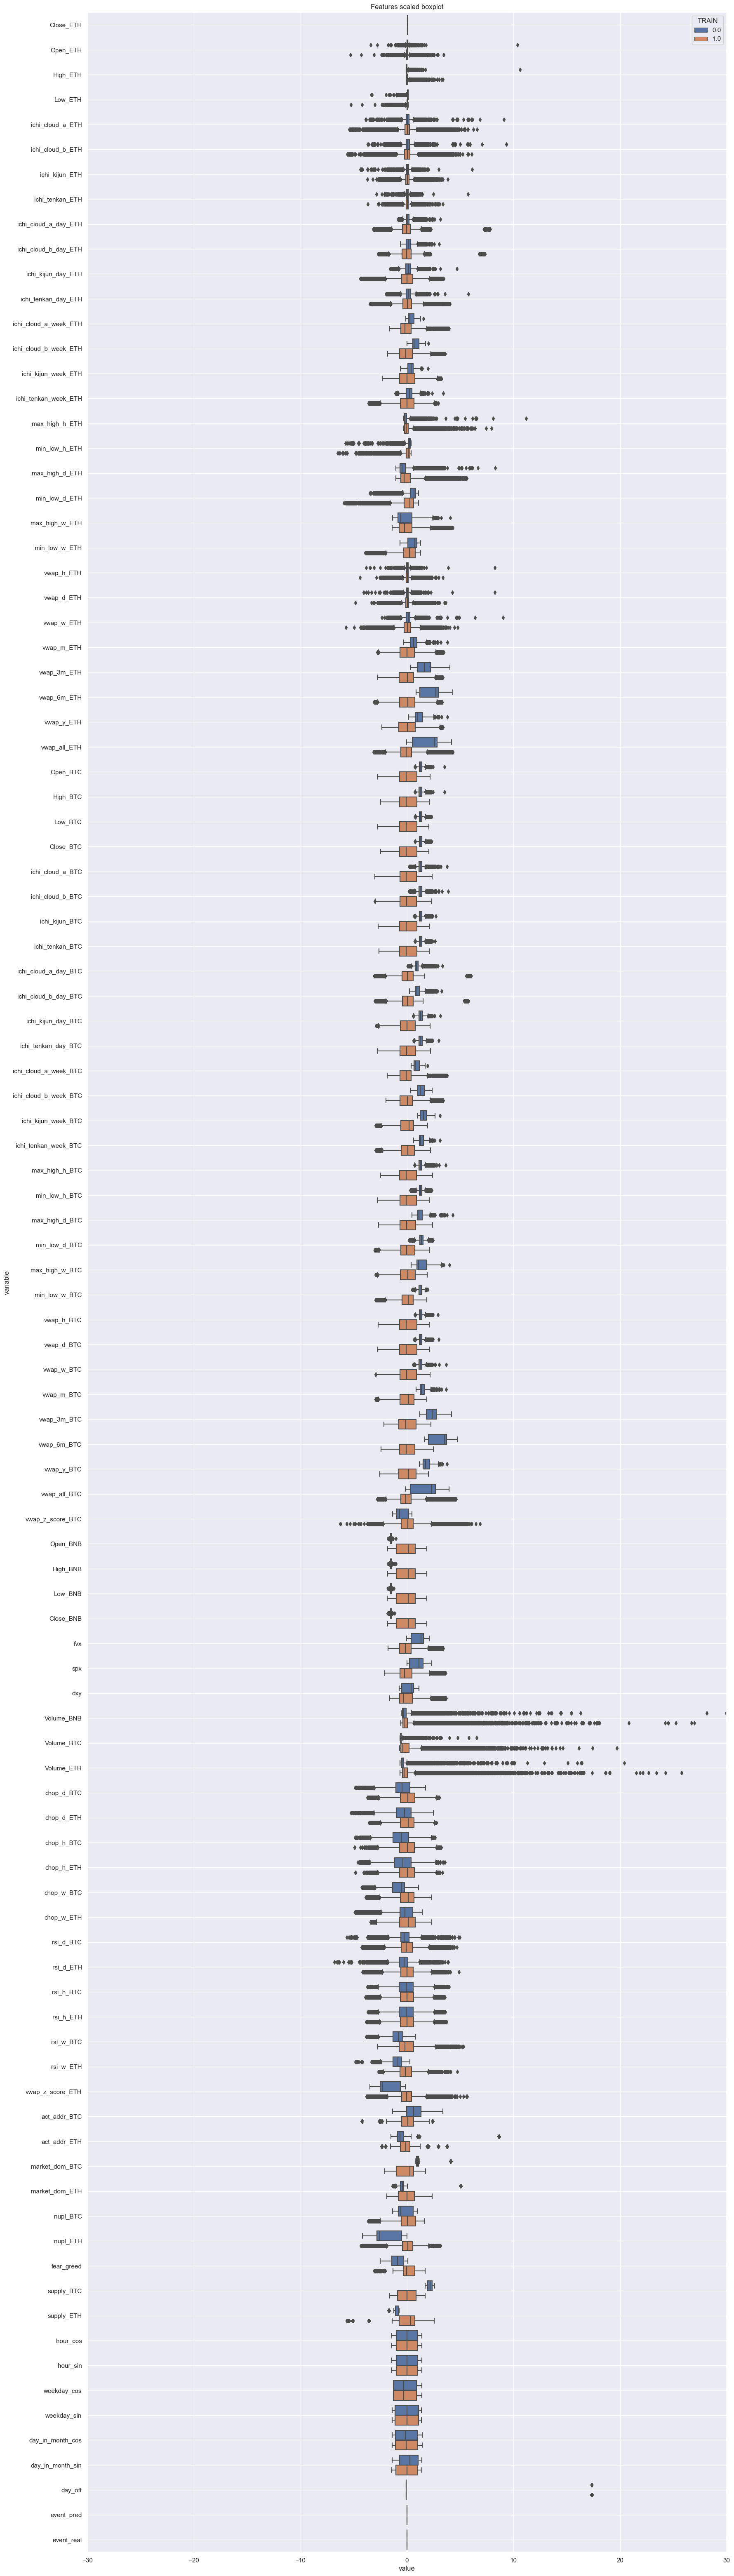

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

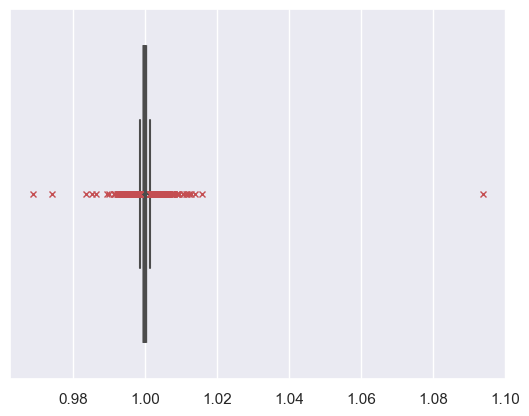

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


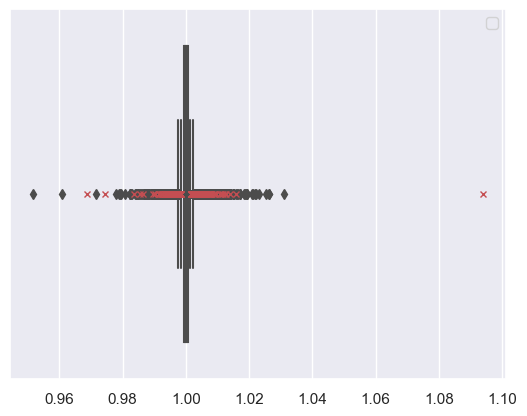

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

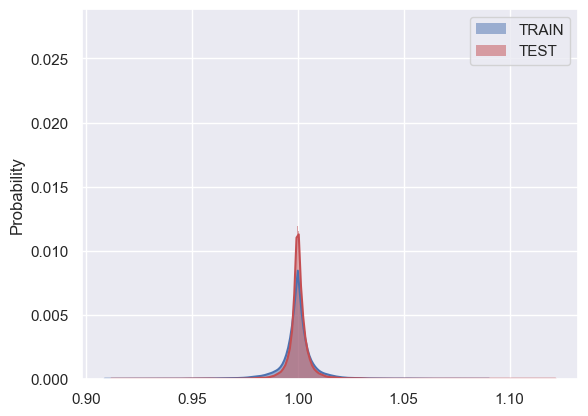

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(60507, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(60507, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.09279669],
       [-0.03408416],
       [-0.19659953],
       ...,
       [-0.1033902 ],
       [-0.03772617],
       [-0.05415363]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(60507, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

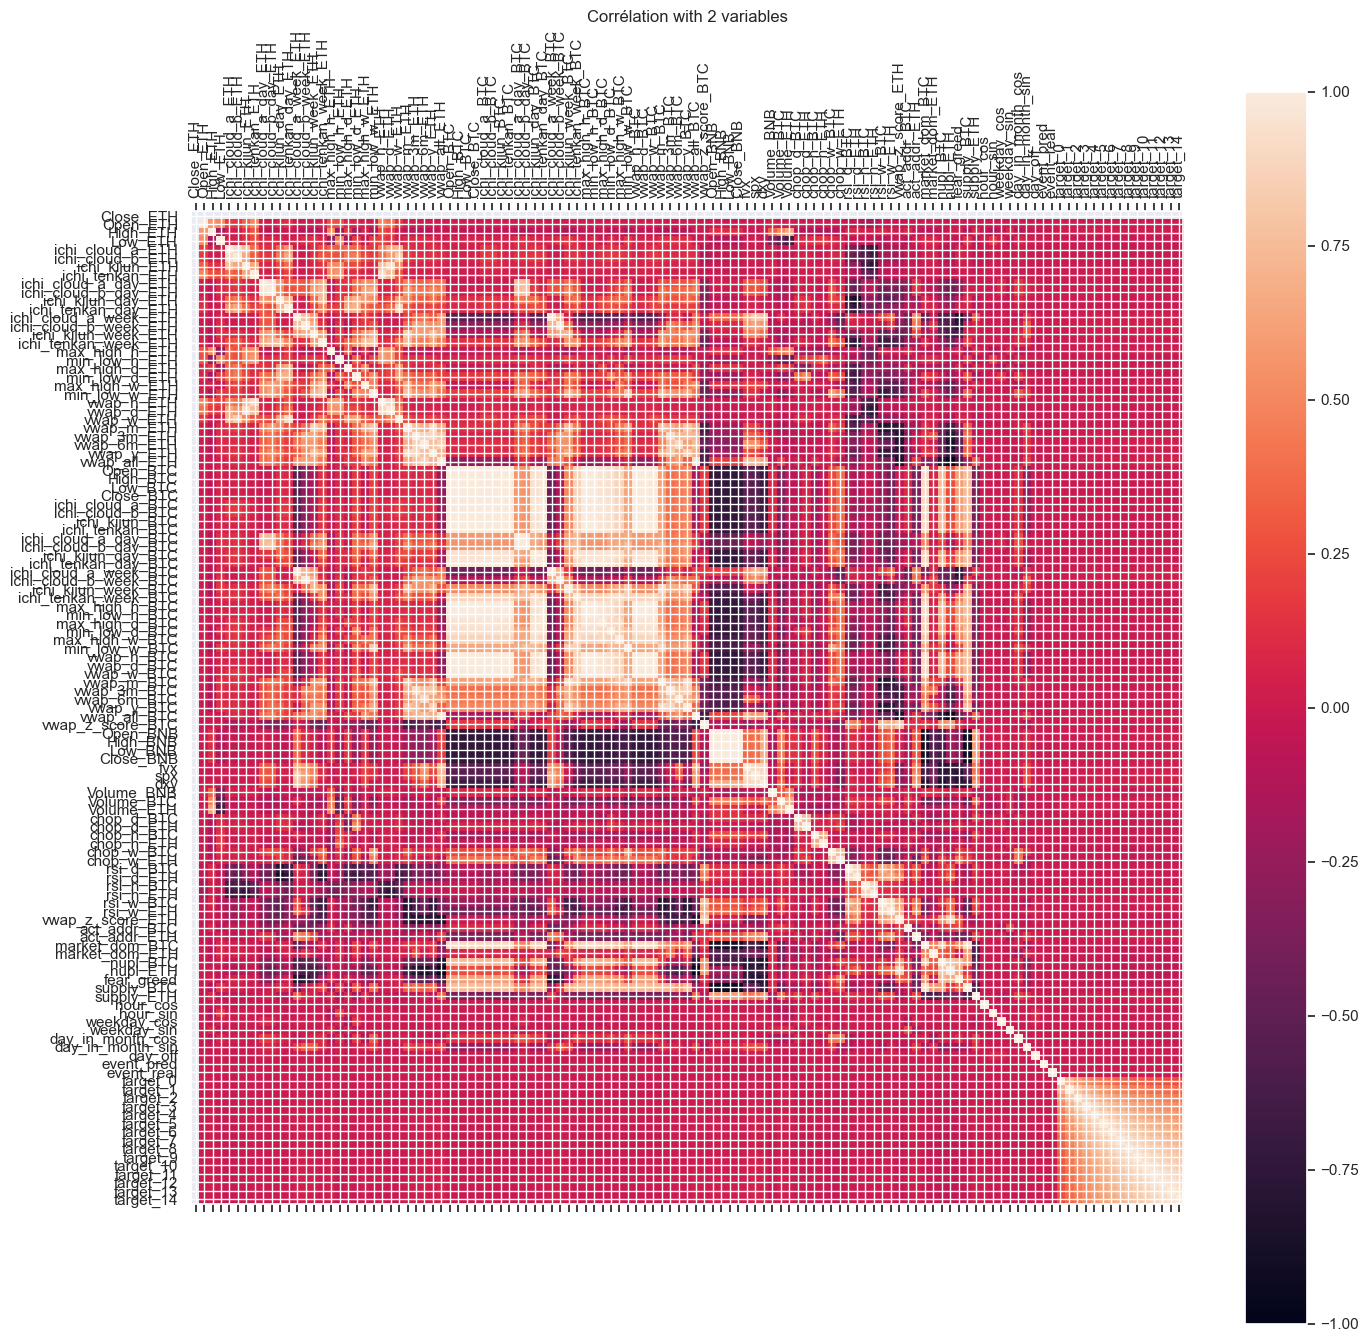

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


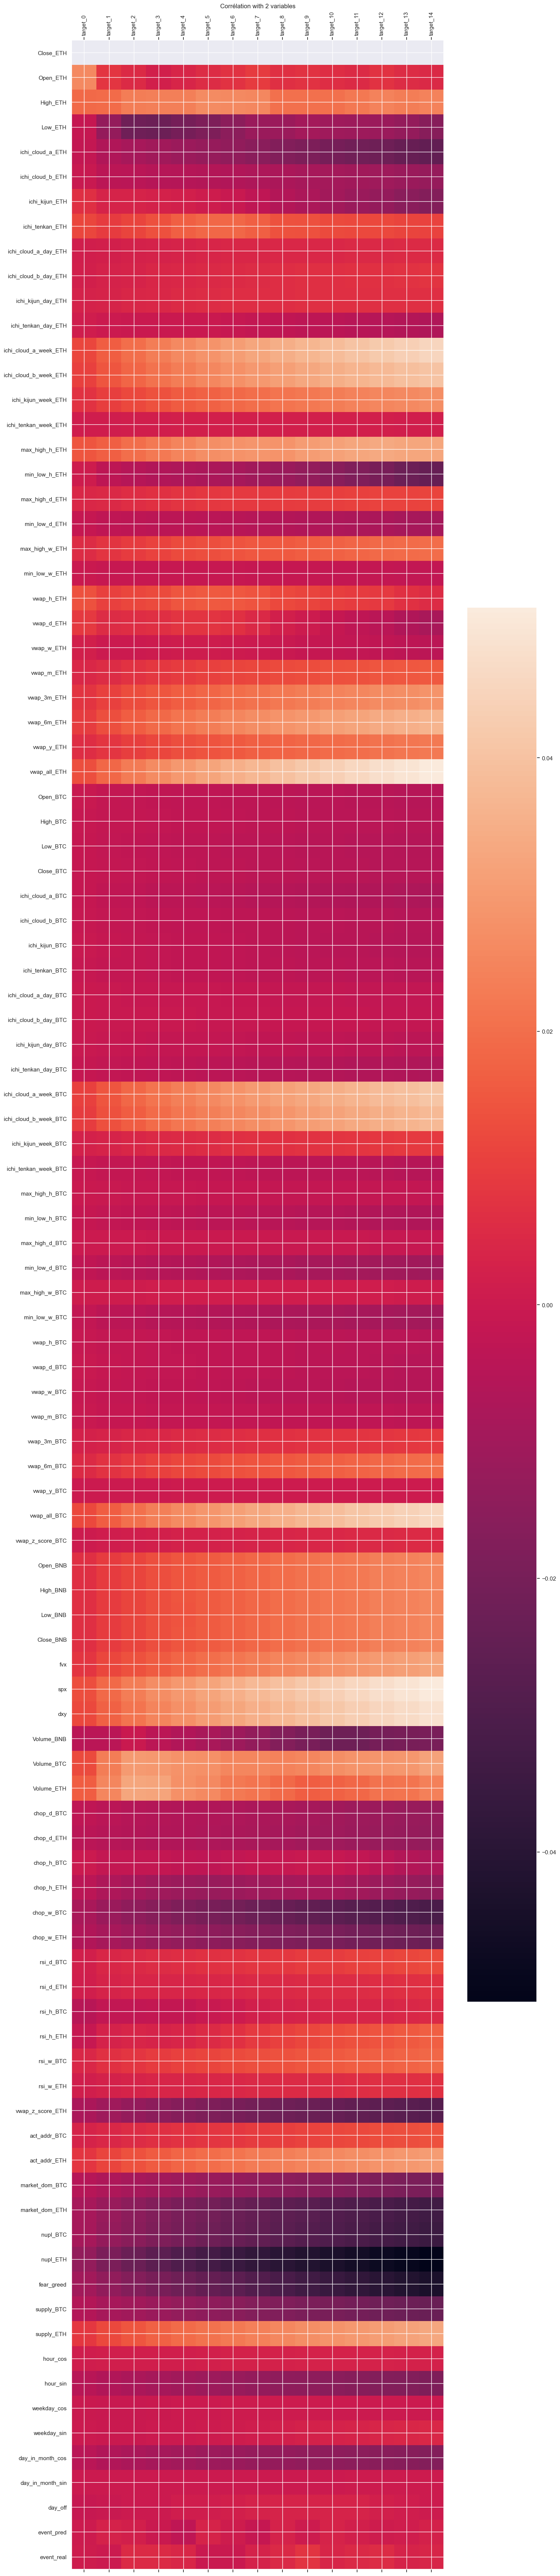

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


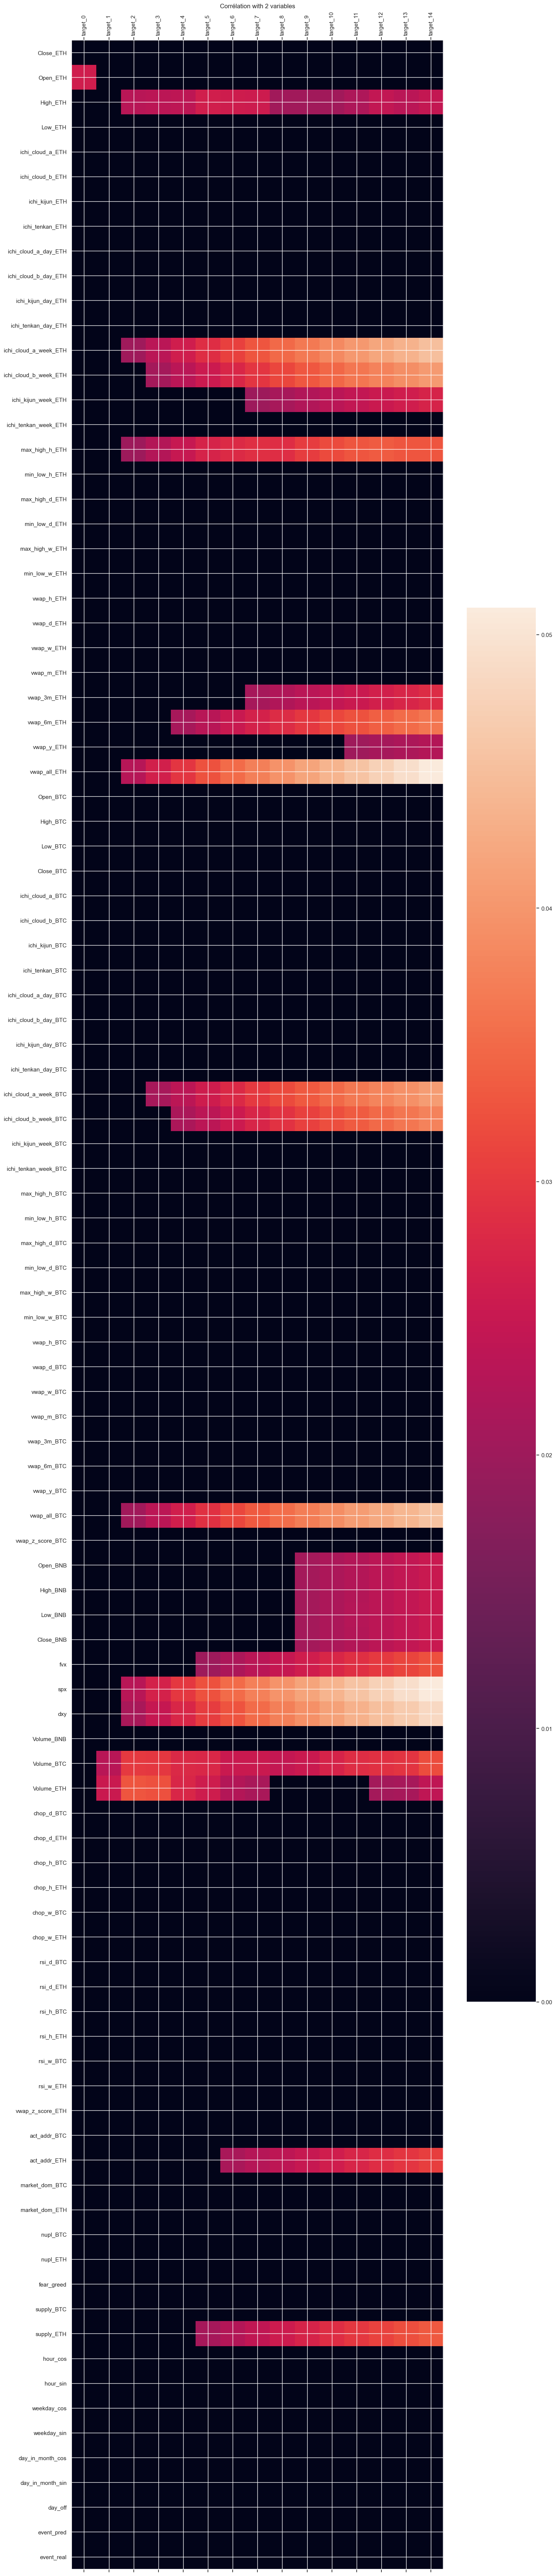

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

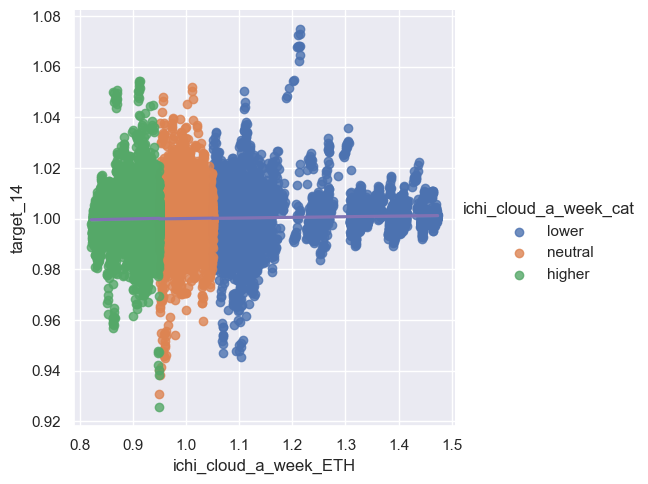

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

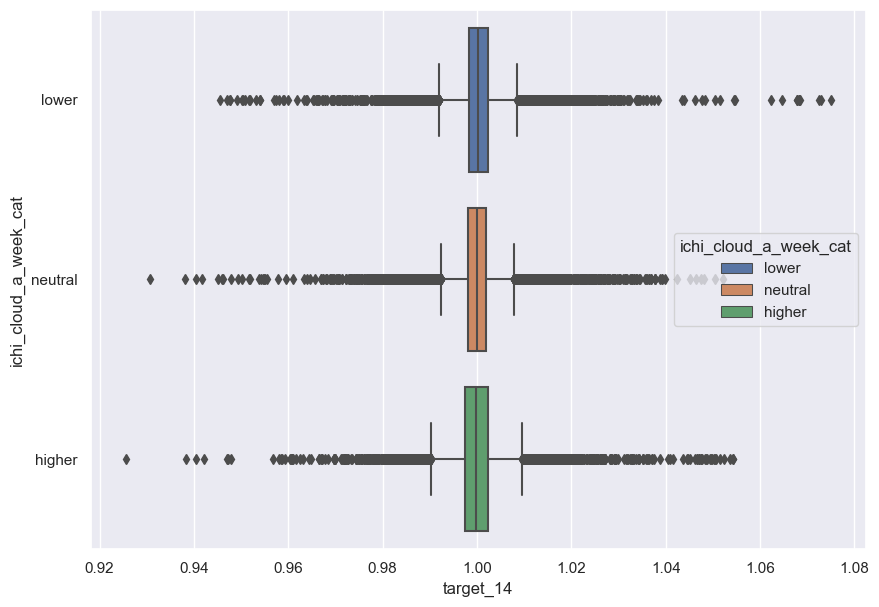

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


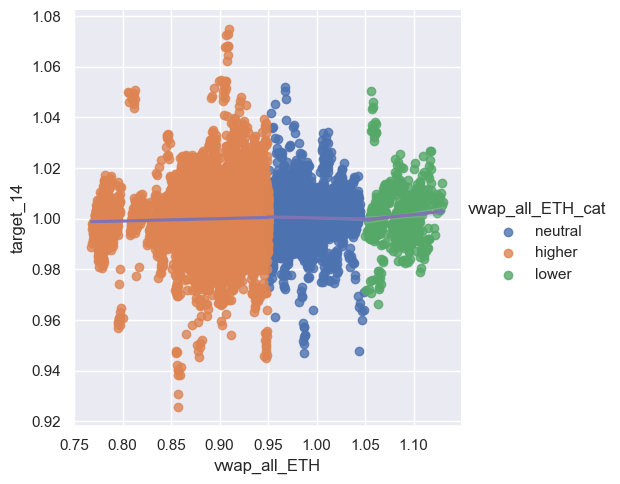

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

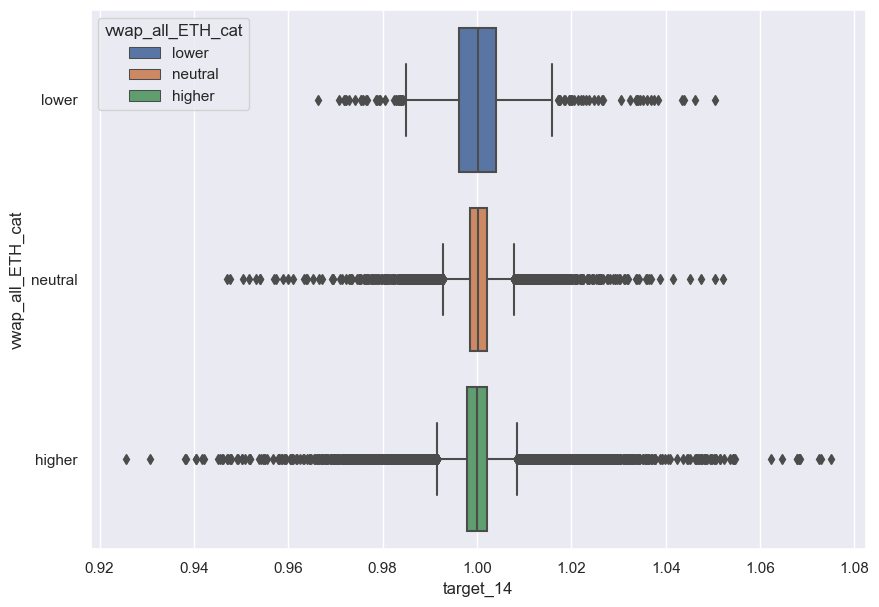

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

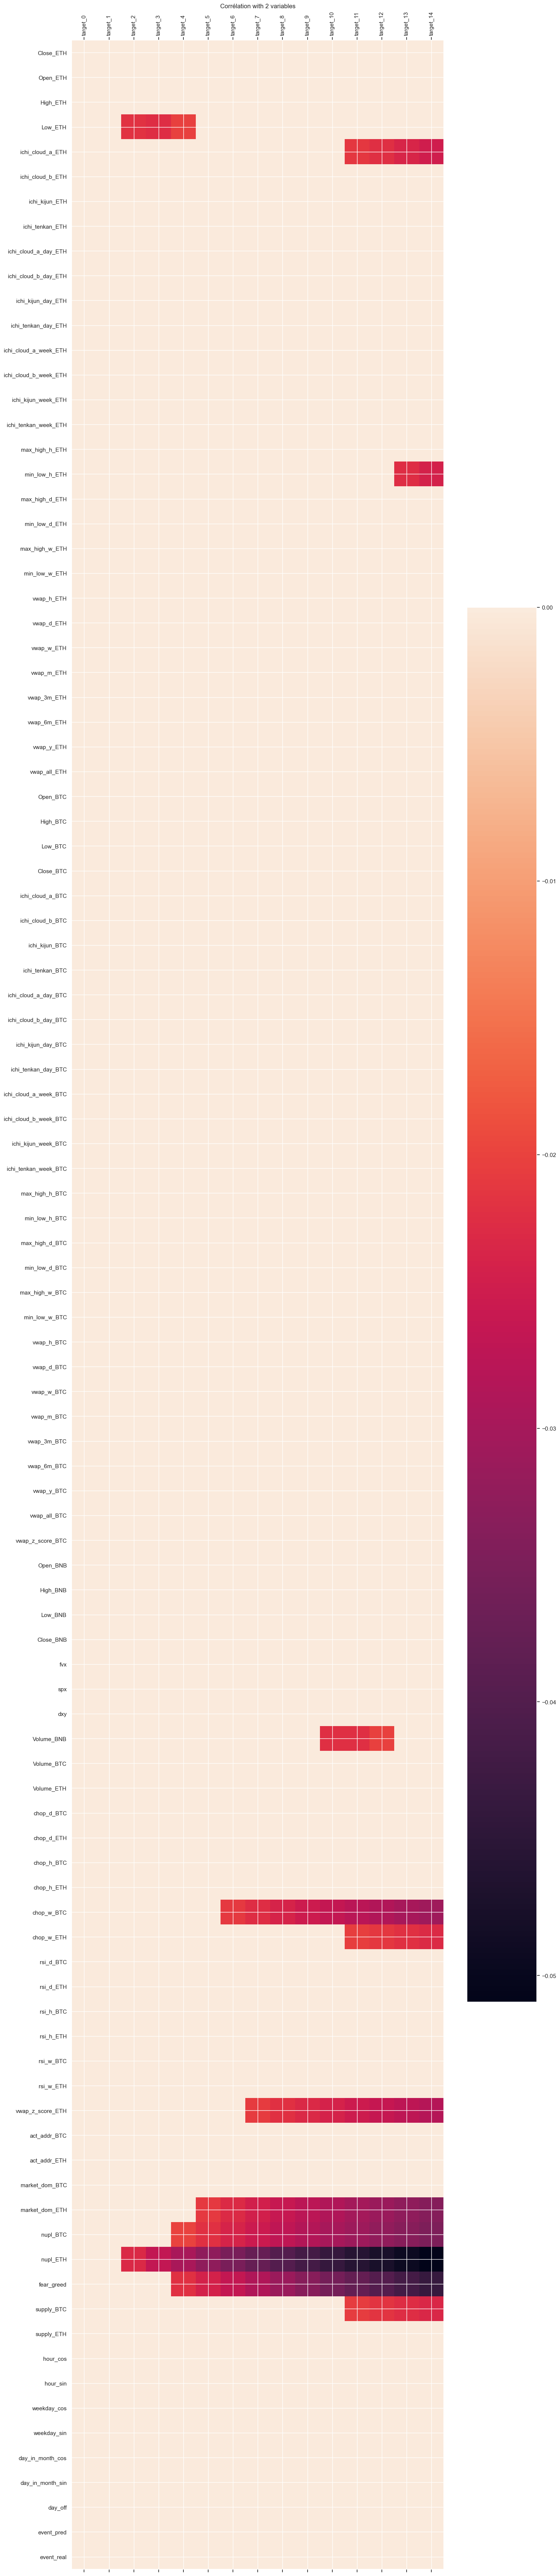

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

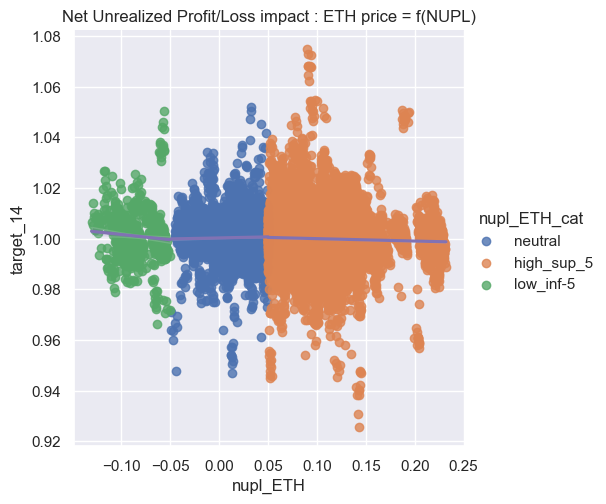

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

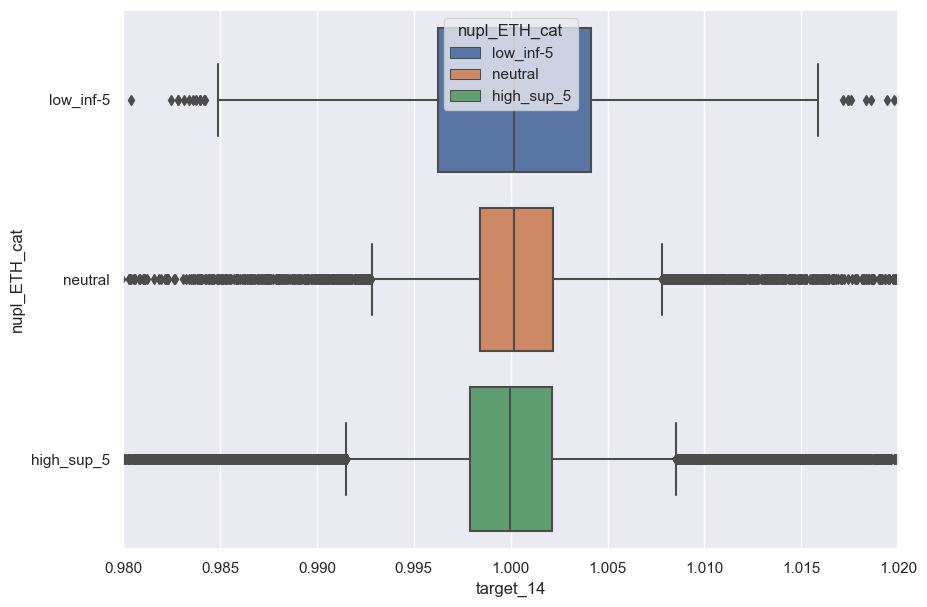

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    60507.000000
mean         1.000128
std          0.005765
min          0.925613
25%          0.997997
50%          1.000032
75%          1.002176
max          1.074927
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    60507.000000
mean         1.000017
std          0.002110
min          0.967271
25%          0.999214
50%          1.000006
75%          1.000811
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

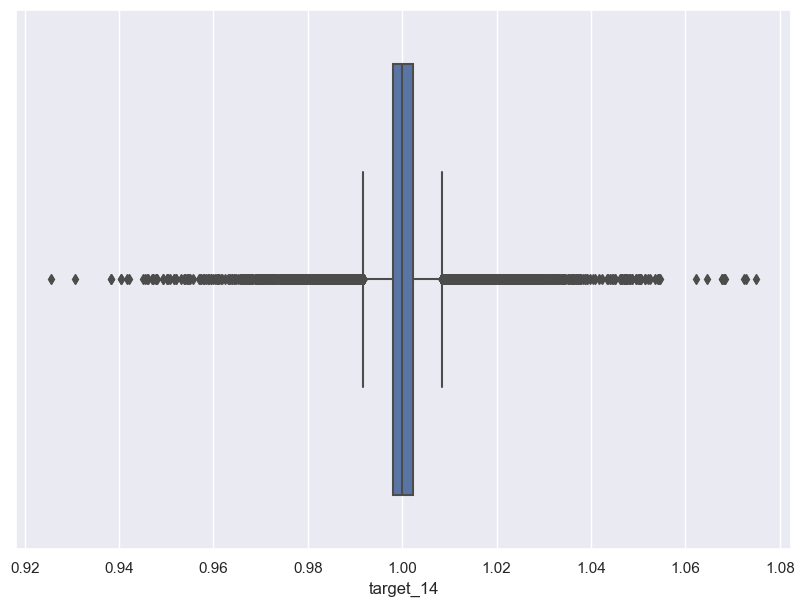

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99963206, 0.9995414 , 0.99938143, ..., 0.9995574 , 0.9991468 ,
        0.99888551],
       [0.99990931, 0.99974928, 0.99971194, ..., 0.99951456, 0.99925317,
        0.99945588],
       [0.99983995, 0.99980261, 1.00003201, ..., 0.9993438 , 0.99954653,
        1.00011203]])

In [89]:
y_train_sca

array([[ 0.09279669,  0.07495292, -0.10546747, ..., -0.04202294,
         0.01943895, -0.0499535 ],
       [-0.03408416, -0.21442152, -0.05588318, ..., -0.08957258,
        -0.1589331 , -0.29963587],
       [-0.19659953, -0.03804926, -0.15101633, ..., -0.14110694,
        -0.28182031, -0.34920417],
       ...,
       [-0.1033902 , -0.12485988, -0.16274753, ..., -0.12107111,
        -0.21831609, -0.28019927],
       [-0.03772617, -0.07562777, -0.08447148, ..., -0.13121679,
        -0.19312274, -0.14511404],
       [-0.05415363, -0.06299814, -0.00866759, ..., -0.17165926,
        -0.12364621,  0.01028493]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(60507, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
seed = 1
epochs = 30 #100 #150 #6 #300
patience = 10 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [64]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [16]:#[16, 20, 32]:
            for dropout_autoenc in [0.25]: #[0.05, 0.15, 0.25]: #[0.25]:
                # check already done ? 
                #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                path_jpg = os.path.join(path_data,
                    f"output_MSE autoencoder - {plt_name}.jpg")
                if (MODE_TRAIN_AE == False):
                    print(f"BE CAREFUL ! training inactivated => no training done...")
                    continue
                print(f"Training: {plt_name} ...")
                # Init
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                # Input dimension
                input_dim = X_train.shape[-1]
                # Reduced encoded input dimension
                # 64/8/0.5
                # Définir l'encodeur
                encoder_inputs = keras.Input(shape=(None, input_dim))
                encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                #encoder = layers.LayerNormalization()(encoder)
                #encoder = layers.Dense(encoding_dim, activation='relu')
                encoder = layers.Dropout(dropout_autoenc)(encoder)
                encoder_outputs = layers.Dense(encoding_dim)(encoder)
                encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                print(encoder_model.summary())
                # Définir le décodeur
                decoder_inputs = keras.Input(shape=(None, encoding_dim))
                decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                #decoder = layers.LayerNormalization()(decoder)
                #decoder = layers.Dense(n_unit_enc, activation='relu')
                decoder = layers.Dropout(dropout_autoenc)(decoder)
                decoder_outputs = layers.Dense(input_dim)(decoder)
                decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                print(decoder_model.summary())
                # Define complete autoencoder 
                autoencoder_inputs = keras.Input(shape=(None, input_dim))
                encoded = encoder_model(autoencoder_inputs)
                decoded = decoder_model(encoded)
                autoencoder = keras.Model(autoencoder_inputs, decoded)
                # Compile : autoencoder
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                #optim = tf.keras.optimizers.Adam()
                autoencoder.compile(optimizer=optim, loss="mse")
                # earlystop 
                es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                monitor='val_loss', mode='auto', restore_best_weights=True)
                # Train
                if patience == 0:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1)
                else:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1, callbacks=[es])

                plot_train_history(
                    autoenc_step_history,f"MSE autoencoder - {plt_name}",
                    saveFolder=path_data)
                #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                            # save the best
                mse_curr = np.min(autoenc_step_history.history['val_loss'])
                print("MSE TEST : ", mse_curr)

                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_unit_enc_min = n_unit_enc
                    encoding_dim_min = encoding_dim
                    dropout_autoenc_min = dropout_autoenc
                    print("Save autoencoder: ", path_mdl_autoencoder)
                    autoencoder.save(path_mdl_autoencoder)
                    print("Save encoder: ", path_mdl_encoder)
                    encoder_model.save(path_mdl_encoder)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())
    n_unit_enc = encoder_model.layers[1].units
    dropout_autoenc = encoder_model.layers[2].rate
    encoding_dim = encoder_model.layers[3].units

print(f"Best model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

Load models...


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 16)          43792     
                                                                 
 model_1 (Functional)        (None, None, 102)         27366     
                                                                 
Total params: 71158 (277.96 KB)
Trainable params: 71158 (277.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 

### Save model

In [95]:
# TODO select best model


In [96]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [97]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [98]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

1891/1891 [==============================] - 46s 24ms/step


(60507, 72, 102)

### Results

In [99]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

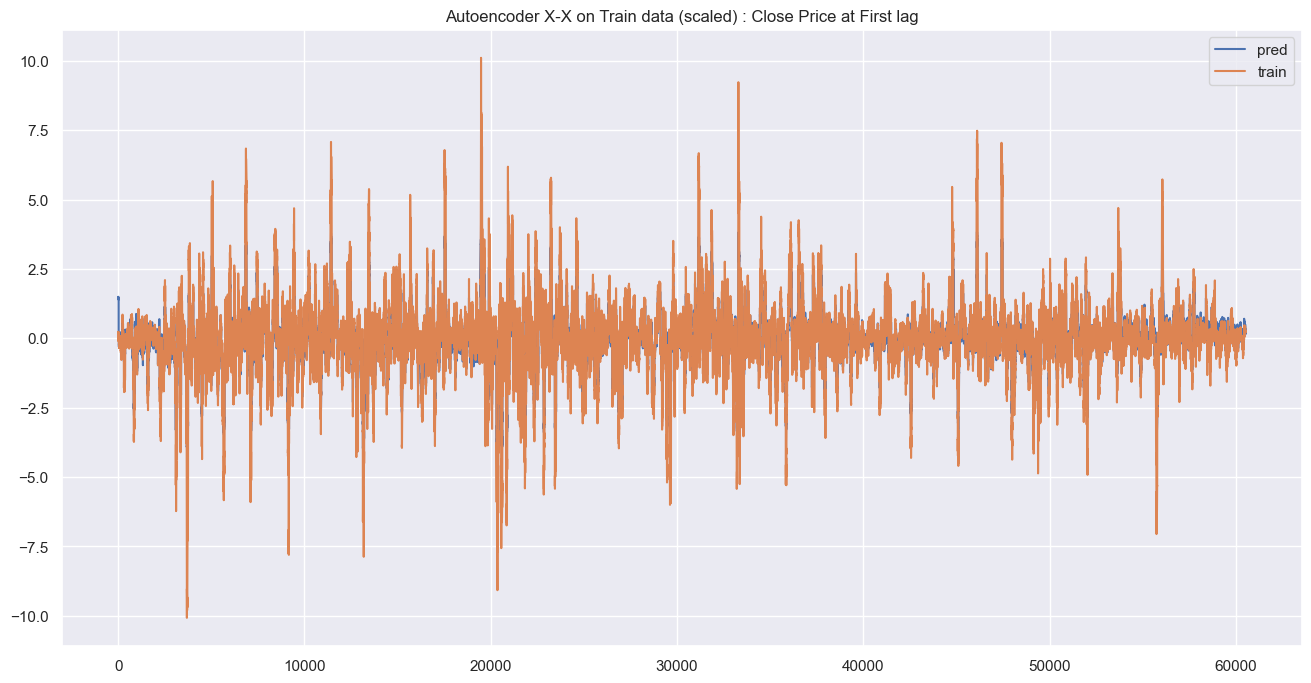

In [100]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [101]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(60507, 72, 102)
(60507, 72, 102)
(72, 102)
(1, 102)


In [102]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.289100  0.291977  0.284814  0.286987          0.352151   
lag_1    0.142181  0.142875  0.134091  0.141165          0.259176   
lag_2    0.134945  0.131688  0.125140  0.131459          0.246533   
lag_3    0.130211  0.124652  0.119414  0.125465          0.239883   
lag_4    0.127143  0.120736  0.115921  0.122373          0.235523   
...           ...       ...       ...       ...               ...   
lag_67   0.096919  0.096391  0.087245  0.095500          0.210904   
lag_68   0.096152  0.095806  0.086539  0.094900          0.210833   
lag_69   0.095437  0.095269  0.085859  0.094258          0.210740   
lag_70   0.094799  0.094647  0.085140  0.093620          0.210632   
lag_71   0.093957  0.094349  0.084382  0.092965          0.210526   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.370296        0.312971         0.308132   
lag_1           0.289968        0.160416         0.156577   
lag_2           0.277872        0.146113         0.140368   
lag_3           0.271599        0.138627         0.130320   
lag_4           0.267441        0.133579         0.123262   
...                  ...             ...              ...   
lag_67          0.241497        0.114654         0.095727   
lag_68          0.241421        0.114378         0.095417   
lag_69          0.241329        0.114138         0.095181   
lag_70          0.241234        0.113883         0.094884   
lag_71          0.241155        0.113612         0.094559   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.353105              0.321729  ...    0.386301  0.766966   
lag_1               0.287864              0.235664  ...    0.283882  0.633322   
lag_2               0.256908              0.203670  ...    0.249309  0.555625   
lag_3               0.236834              0.185557  ...    0.231325  0.507484   
lag_4               0.220780              0.171801  ...    0.218509  0.475914   
...                      ...                   ...  ...         ...       ...   
lag_67              0.162523              0.120377  ...    0.180068  0.373595   
lag_68              0.162455              0.120278  ...    0.179986  0.373368   
lag_69              0.162374              0.120191  ...    0.179926  0.373149   
lag_70              0.162283              0.120093  ...    0.179854  0.372946   
lag_71              0.162204              0.119976  ...    0.179801  0.372742   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.756345     0.723553     0.737409          0.714341   
lag_1   0.637418     0.559605     0.588589          0.565342   
lag_2   0.577069     0.470750     0.512757          0.493346   
lag_3   0.541716     0.415362     0.470169          0.445933   
lag_4   0.518841     0.378578     0.442968          0.410232   
...          ...          ...          ...               ...   
lag_67  0.447624     0.286036     0.360210          0.243232   
lag_68  0.447499     0.285846     0.360041          0.243214   
lag_69  0.447355     0.285664     0.359909          0.243178   
lag_70  0.447201     0.285497     0.359781          0.243115   
lag_71  0.447062     0.285353     0.359609          0.243087   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.655989  0.434892    0.031453    0.033406  
lag_1           0.488513  0.392963    0.033835    0.036443  
lag_2           0.417407  0.322026    0.032493    0.035585  
lag_3           0.373550  0.275054    0.032235    0.035018  
lag_4           0.345131  0.240272    0.032200    0.034591  
...                  ...       ...         ...         ...  
lag_67          0.249698  0.131810    0.032448    0.032006  
lag_68          0.249554  0.131659    0.032440    0.031976  
lag_69          0.249422  0.131488    0.032433    0.031946  
lag_70          0.249325  0.131360    0.032426    0.031923  
lag_71          0.249230  0.13117

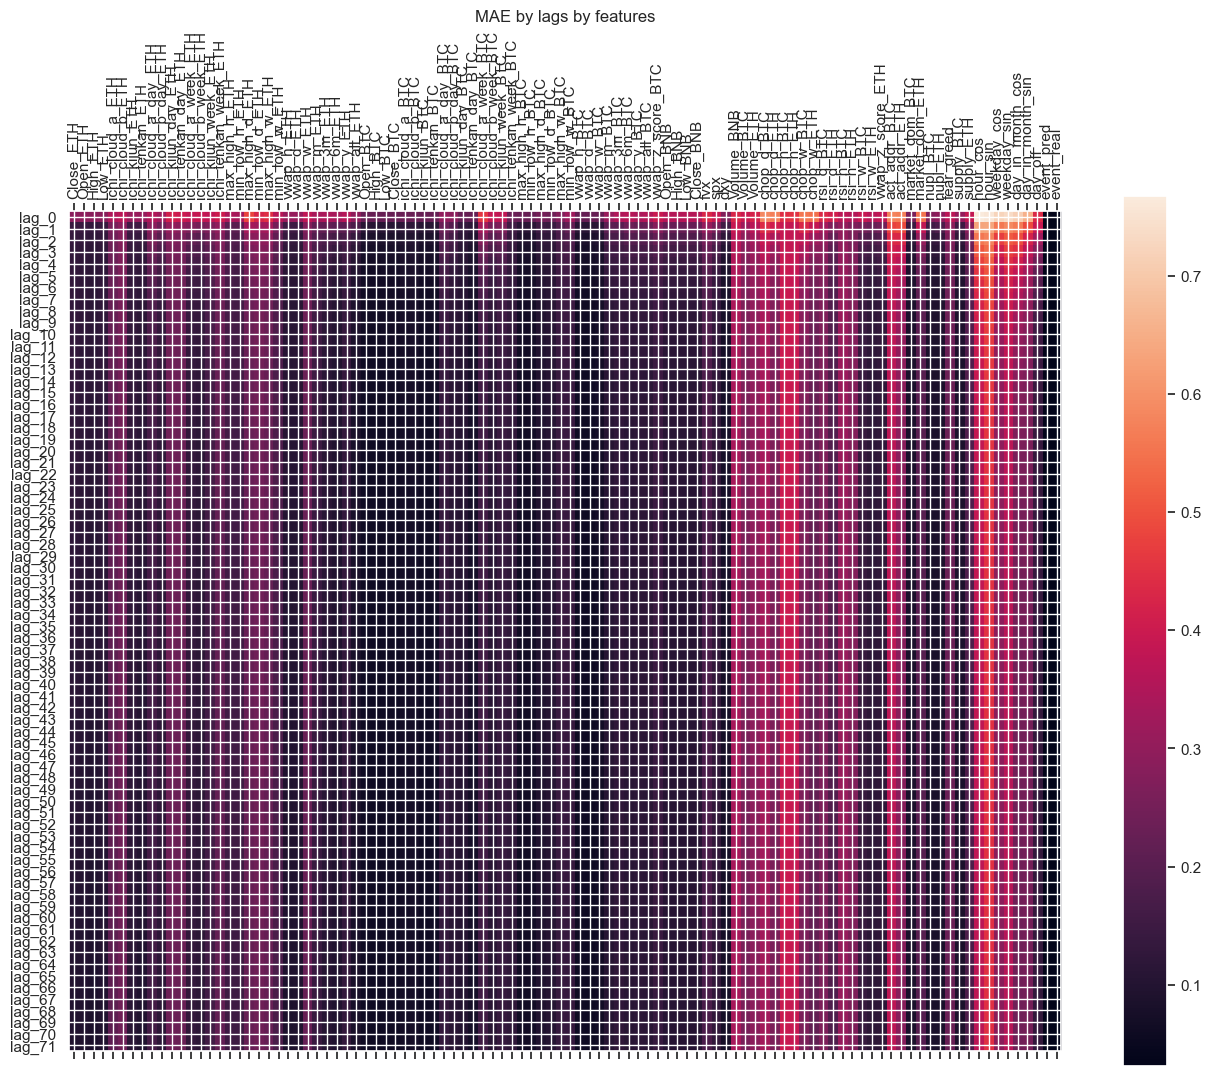

In [103]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

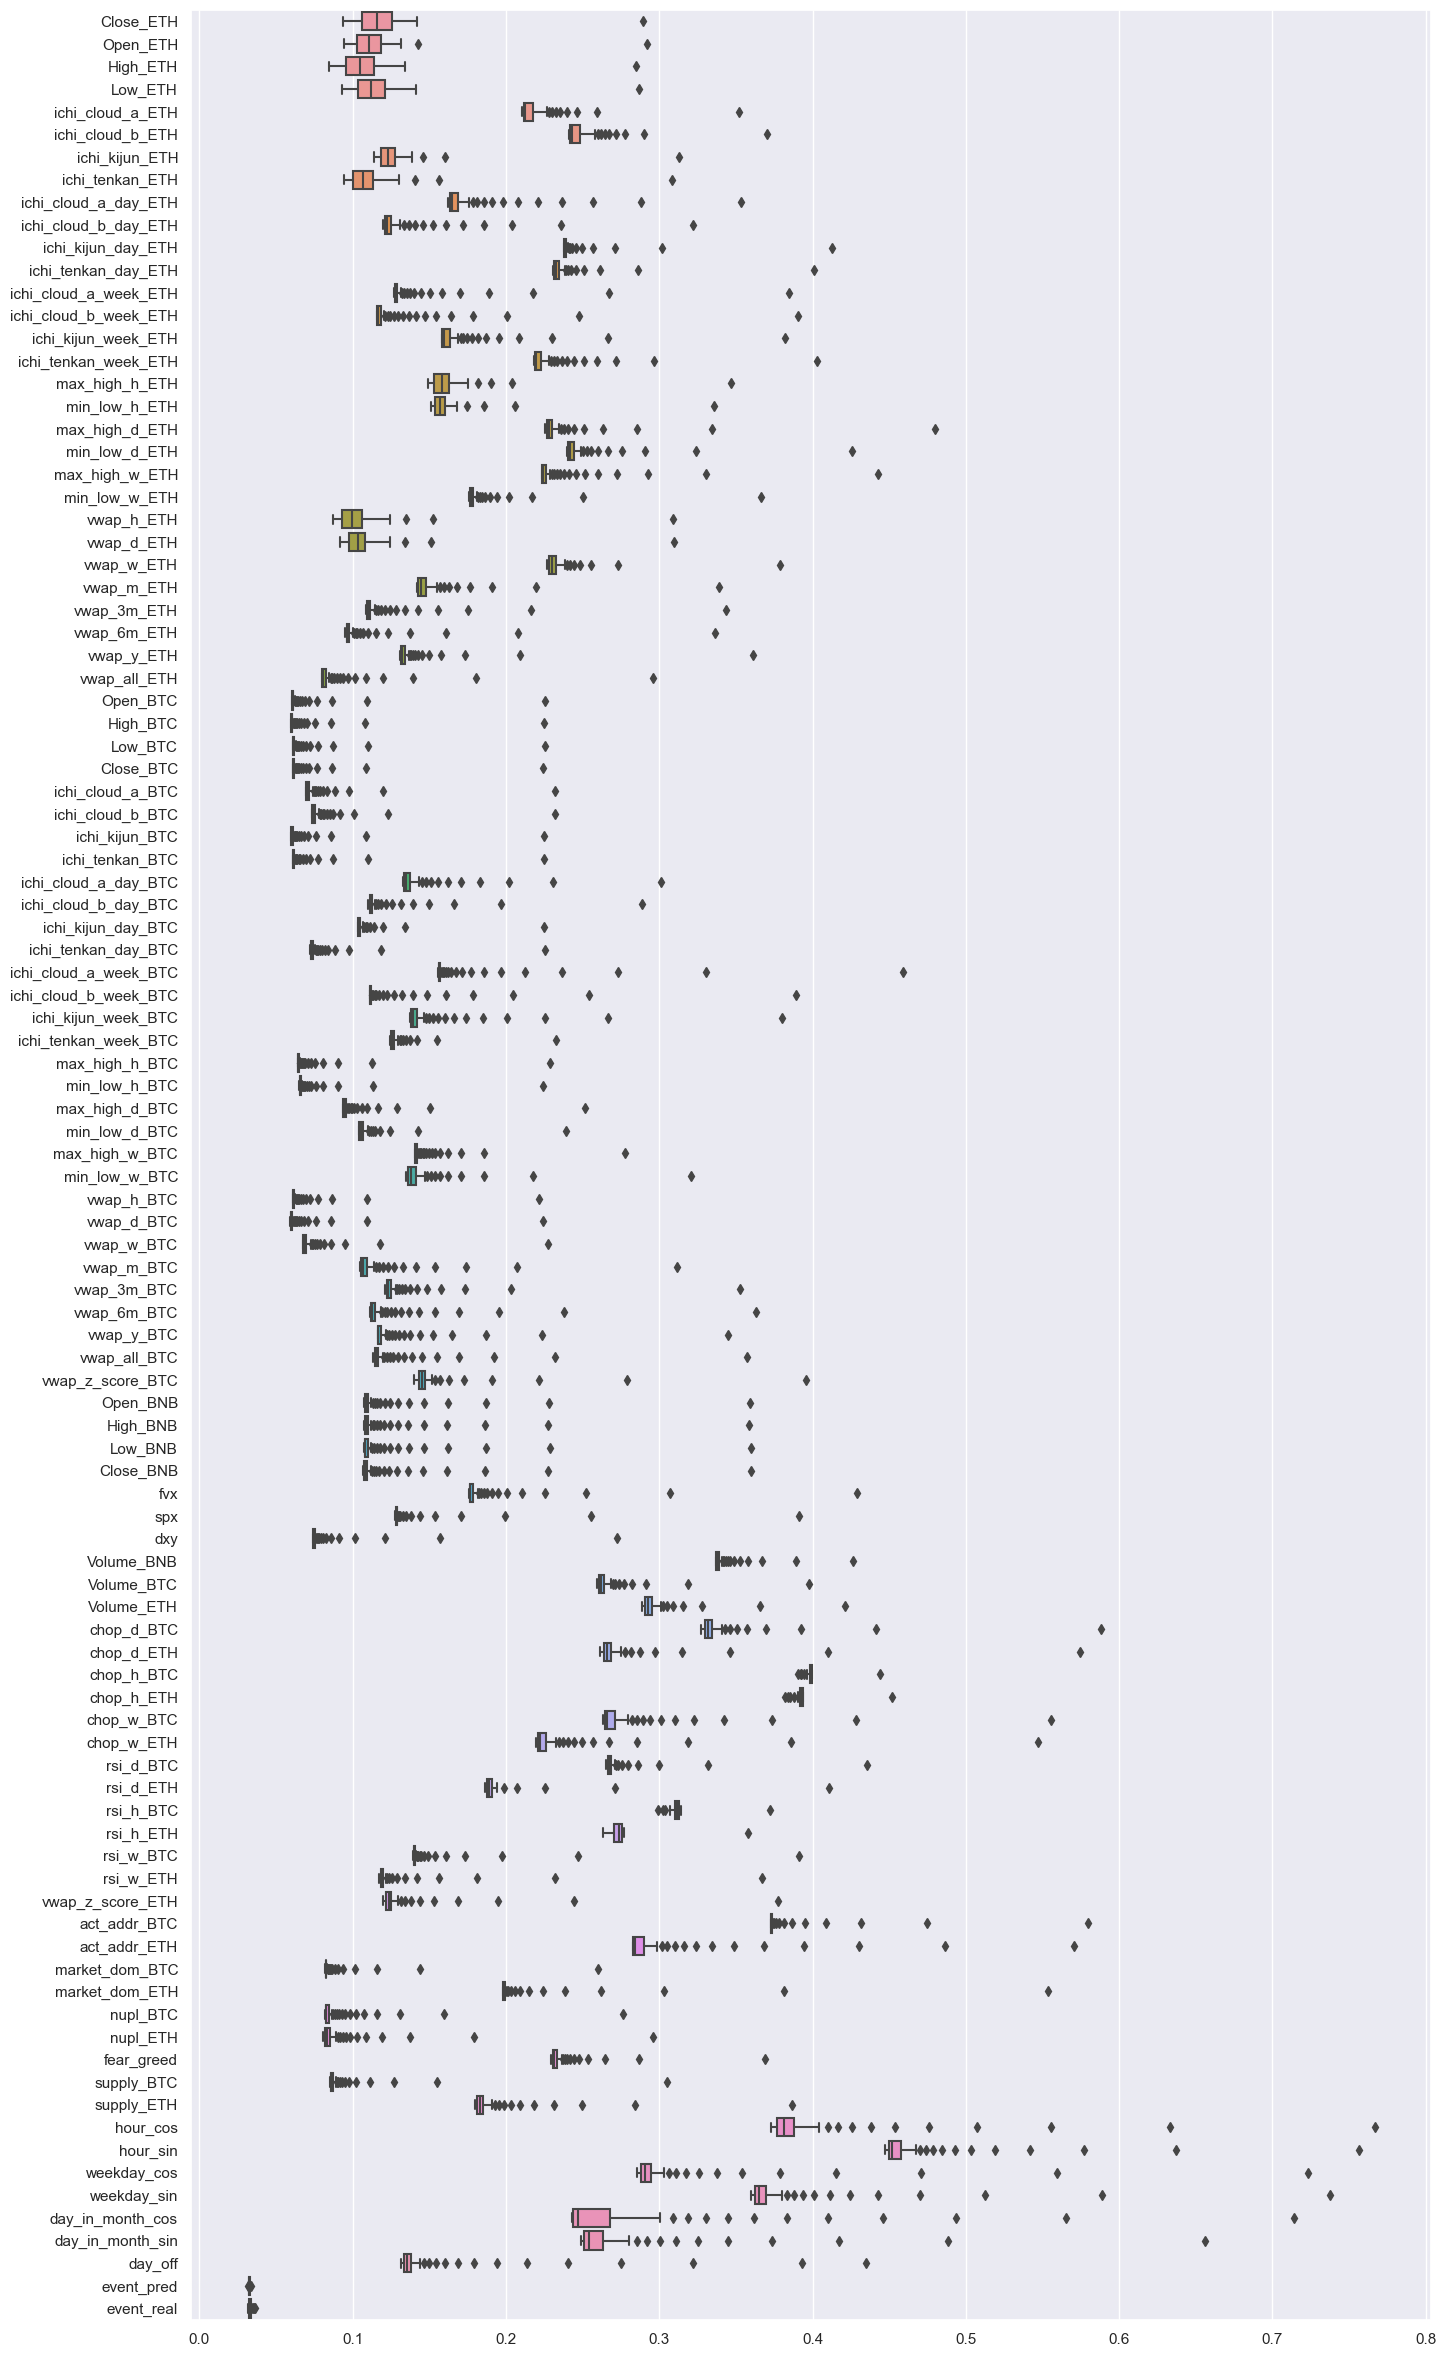

In [104]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [105]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.117322  0.112855  0.106475  0.114022           0.21826   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.248649        0.126175         0.110631              0.174689   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.131476  ...    0.190291  0.398922  0.465585     0.308461   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.380802          0.278163          0.272867  0.152656    0.032557   

   event_real  
0    0.033025  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

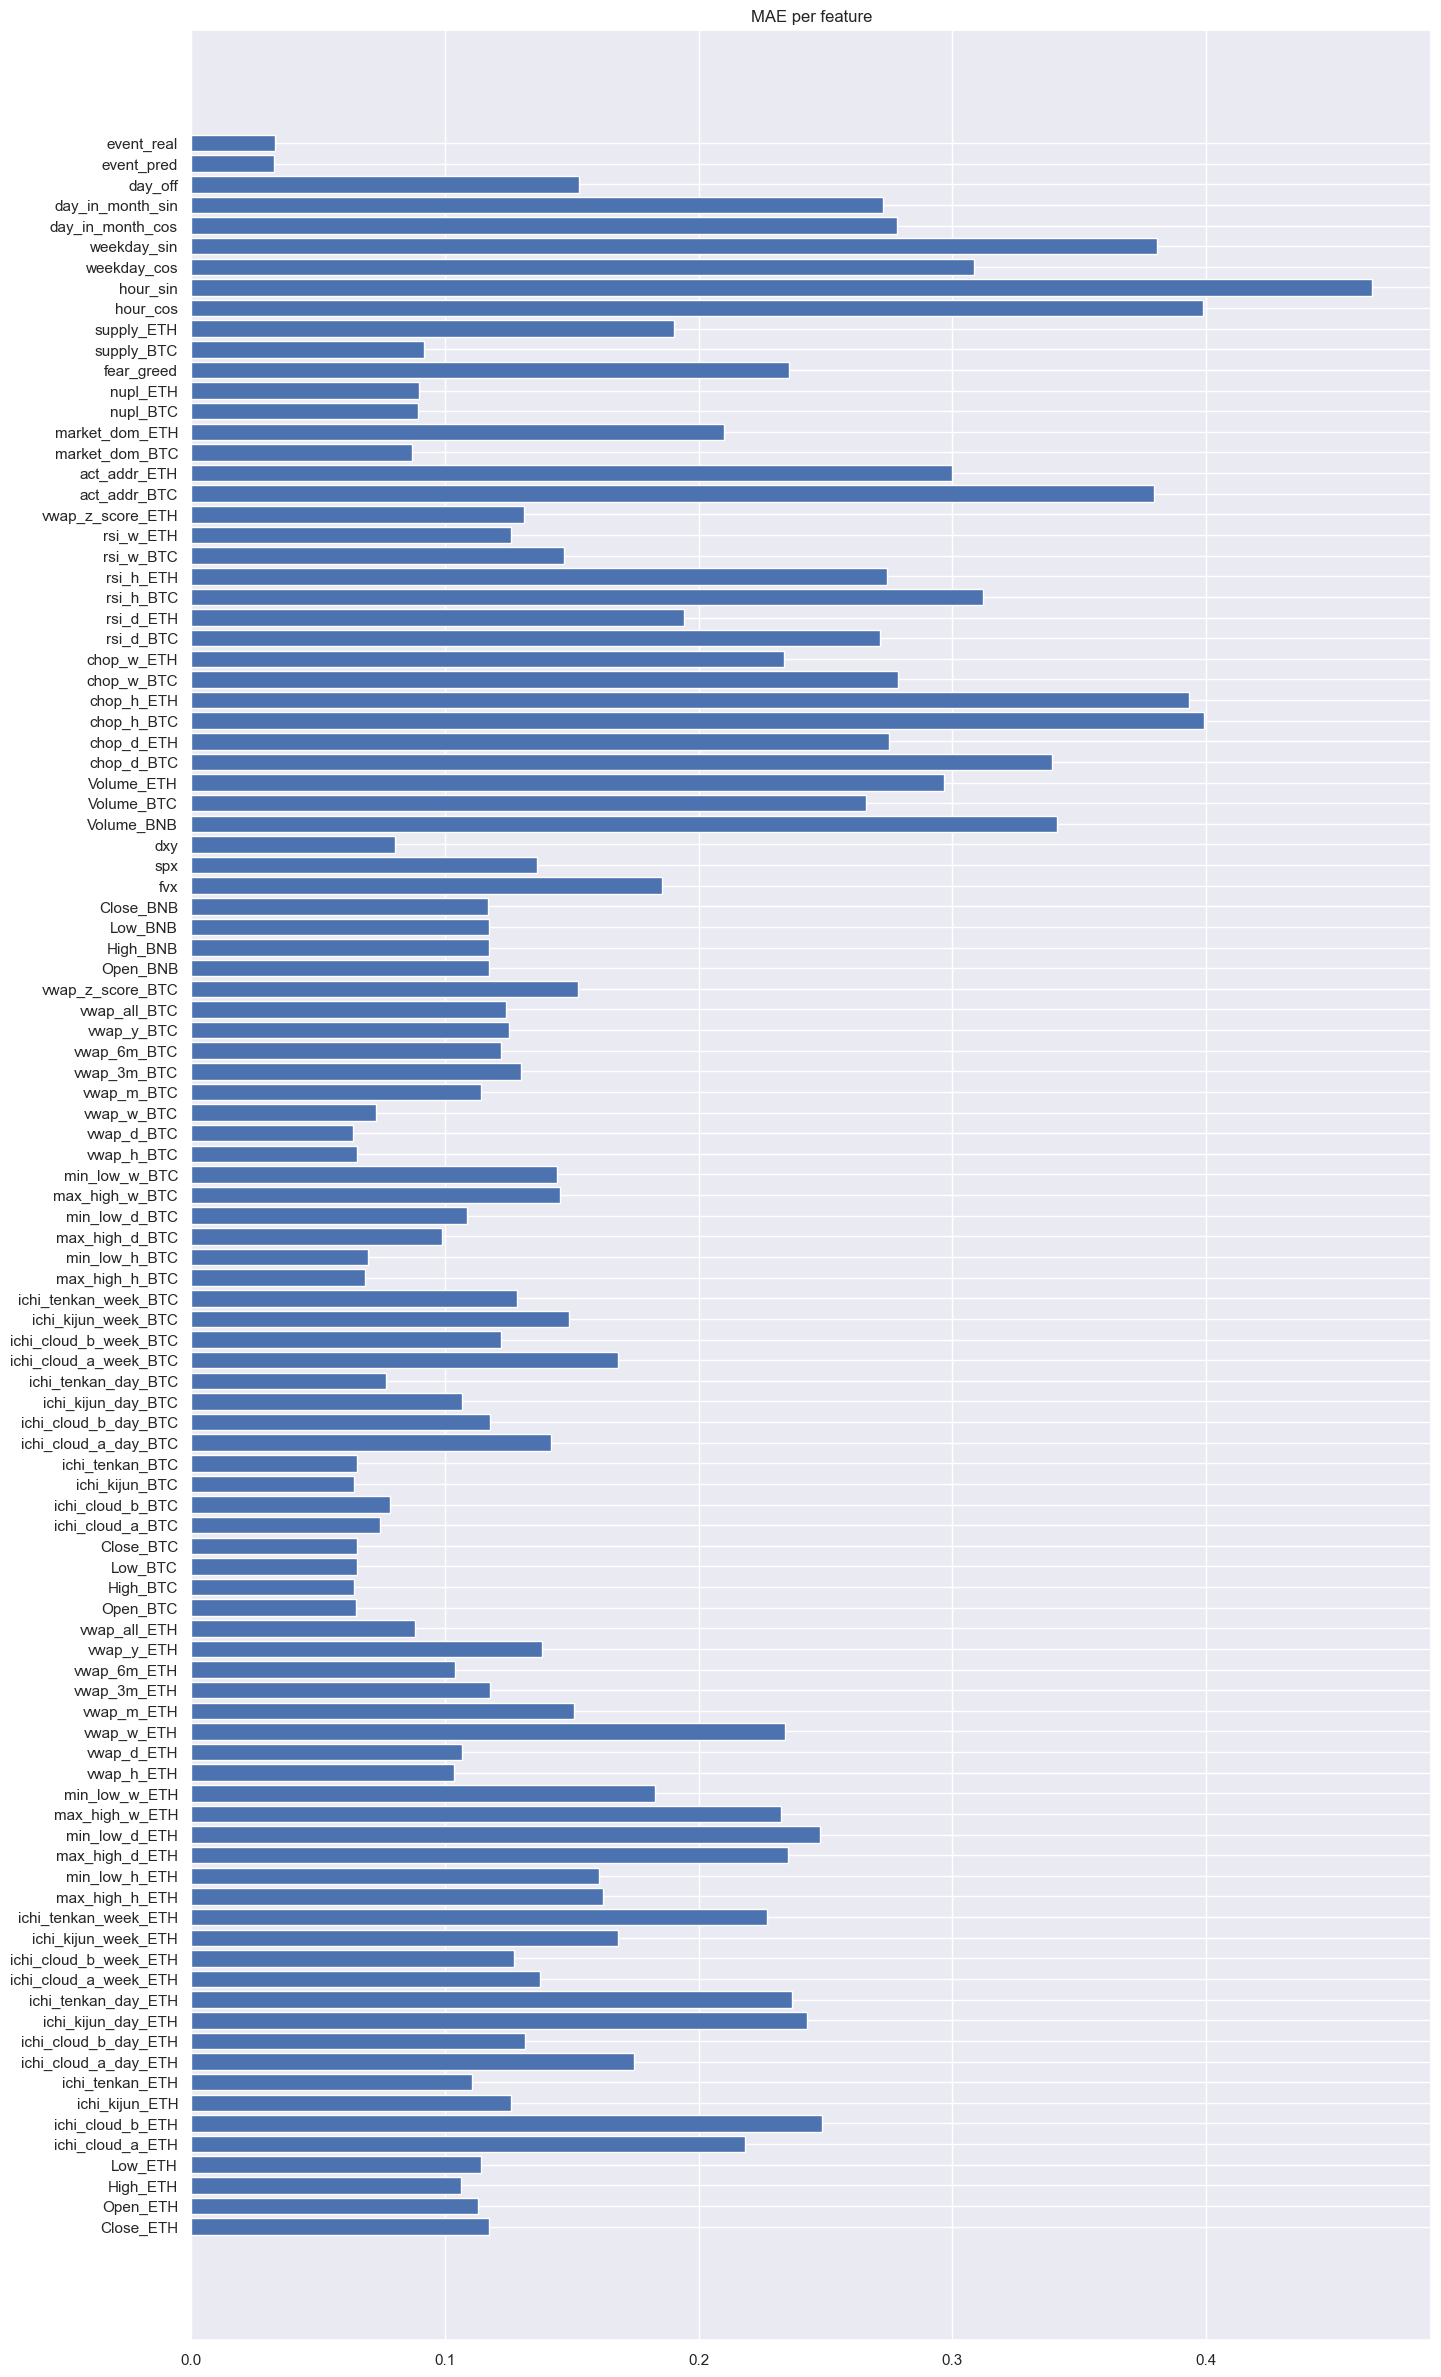

In [106]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [107]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(60507,)
(60507,)
[1196.32 1195.38 1194.55 ... 1878.19 1878.79 1878.79]
[1196.32 1195.38 1194.55]


In [108]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9990121 , 0.9994085 , 0.99950826, ..., 1.0009687 , 1.0007592 ,
       1.0002562 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1878.19 1878.79 1878.79]
[1210.23763558 1210.70211796 1210.66550255 ... 1877.39049448 1877.78131514
 1877.4798618 ]


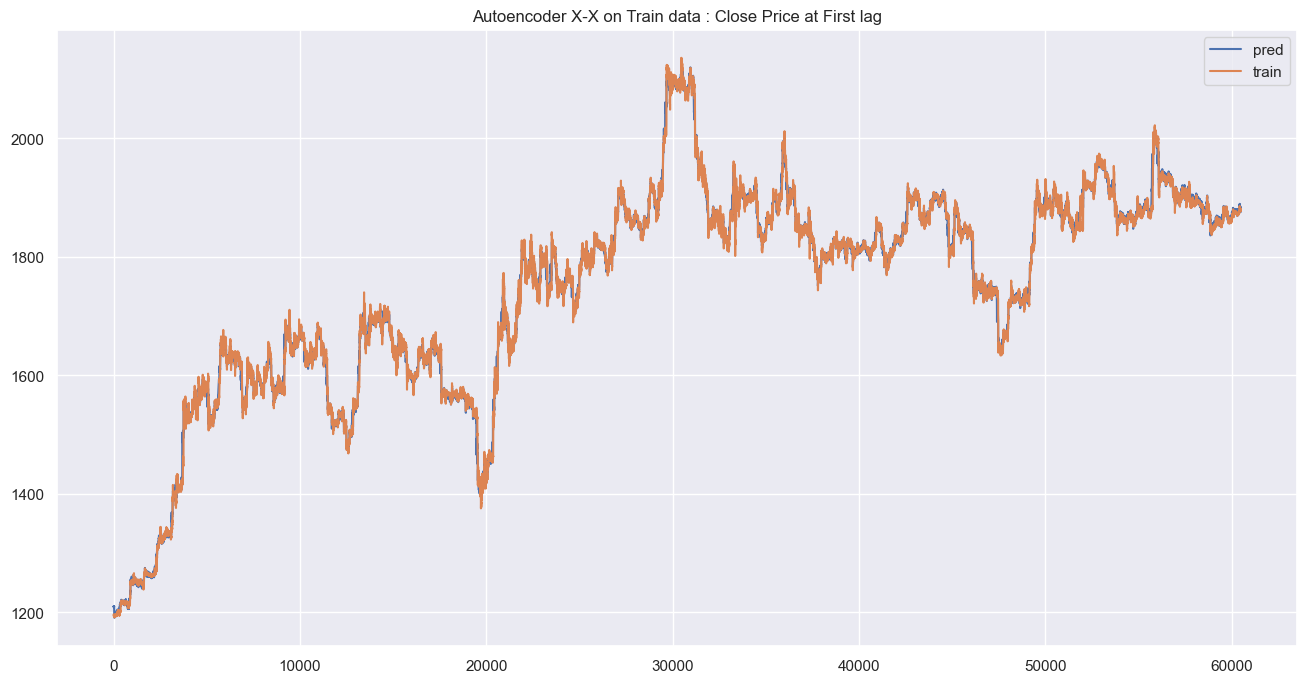

In [109]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [110]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

471/471 [==============================] - 13s 28ms/step


(15060, 72, 102)

In [111]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-07-30 09:25:00'

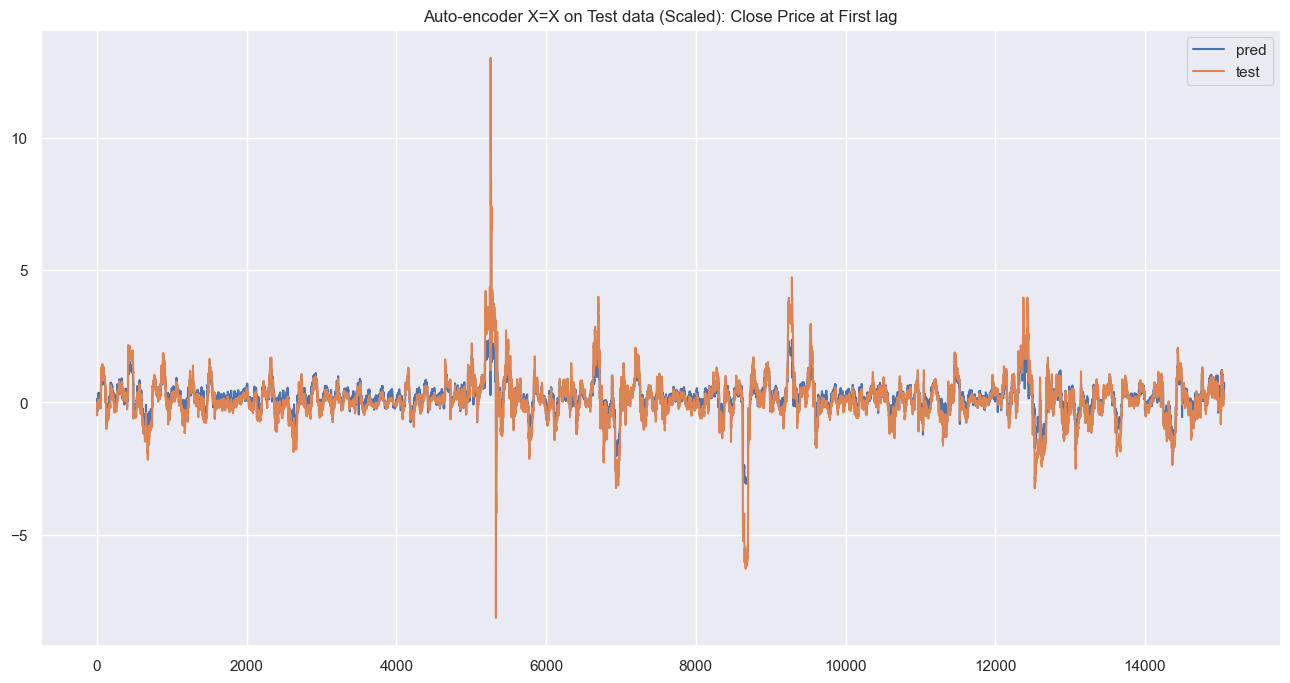

In [112]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [113]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1873.38 1873.77 1873.35 1873.11 1873.39 1873.53 1874.5  1875.31 1875.1 ]
X test pred :  [1876.53851744 1875.15637493 1875.27673495 1874.6041362  1874.40426431
 1873.54612892 1875.39745671 1877.91644367 1878.54890801]


[1873.38 1873.77 1873.35 ... 1628.89 1628.02 1627.28]
[1876.53851744 1875.15637493 1875.27673495 ... 1634.44335558 1633.45126184
 1631.77587275]


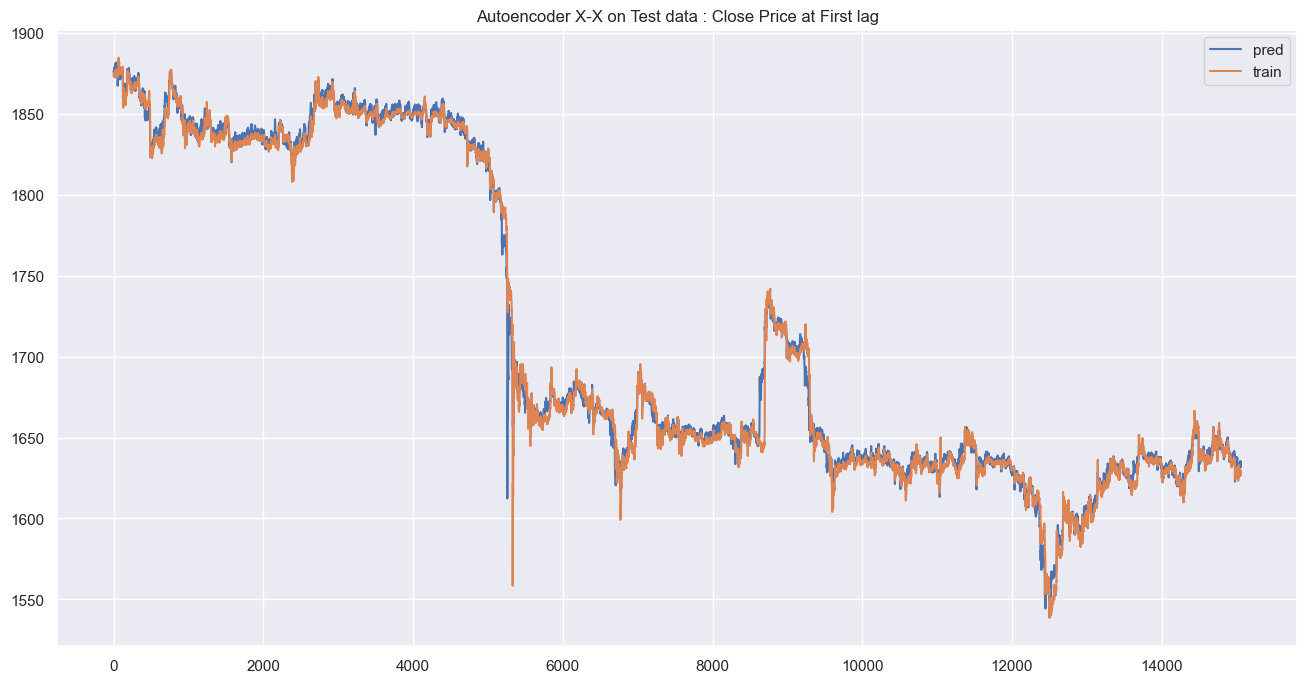

In [114]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [115]:
X_test_sca.shape

(15060, 72, 102)

In [116]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.5125044673644904

In [117]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(15060, 72, 102)
(15060, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.289100  0.291977  0.284814  0.286987          0.352151   
lag_1    0.142181  0.142875  0.134091  0.141165          0.259176   
lag_2    0.134945  0.131688  0.125140  0.131459          0.246533   
lag_3    0.130211  0.124652  0.119414  0.125465          0.239883   
lag_4    0.127143  0.120736  0.115921  0.122373          0.235523   
...           ...       ...       ...       ...               ...   
lag_67   0.106987  0.106343  0.107526  0.105403          0.171477   
lag_68   0.105946  0.105703  0.106559  0.104528          0.171246   
lag_69   0.104760  0.104783  0.105513  0.103708          0.171056   
lag_70   0.103638  0.103896  0.104407  0.102702          0.170824   
lag_71   0.102344  0.102831  0.103408  0.101568          0.170716   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.370296        0.312971         0.308132   
lag_1           0.289968        0.160416         0.156577   
lag_2           0.277872        0.146113         0.140368   
lag_3           0.271599        0.138627         0.130320   
lag_4           0.267441        0.133579         0.123262   
...                  ...             ...              ...   
lag_67          0.197891        0.116491         0.108695   
lag_68          0.197628        0.115968         0.108100   
lag_69          0.197346        0.115450         0.107422   
lag_70          0.197090        0.114775         0.106670   
lag_71          0.196886        0.114068         0.105998   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.353105              0.321729  ...  0.766966  0.756345   
lag_1               0.287864              0.235664  ...  0.633322  0.637418   
lag_2               0.256908              0.203670  ...  0.555625  0.577069   
lag_3               0.236834              0.185557  ...  0.507484  0.541716   
lag_4               0.220780              0.171801  ...  0.475914  0.518841   
...                      ...                   ...  ...       ...       ...   
lag_67              0.295253              0.326621  ...  0.474684  0.520088   
lag_68              0.295298              0.326603  ...  0.474639  0.519799   
lag_69              0.295312              0.326576  ...  0.474554  0.519505   
lag_70              0.295355              0.326557  ...  0.474460  0.519175   
lag_71              0.295401              0.326567  ...  0.474357  0.518832   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.723553     0.737409          0.714341          0.655989   
lag_1      0.559605     0.588589          0.565342          0.488513   
lag_2      0.470750     0.512757          0.493346          0.417407   
lag_3      0.415362     0.470169          0.445933          0.373550   
lag_4      0.378578     0.442968          0.410232          0.345131   
...             ...          ...               ...               ...   
lag_67     0.452725     0.575117          1.026372          0.608369   
lag_68     0.452451     0.574982          1.026521          0.608406   
lag_69     0.452167     0.574849          1.026674          0.608410   
lag_70     0.451931     0.574804          1.026818          0.608412   
lag_71     0.451644     0.574768          1.026963          0.608386   

         day_off  event_pred  event_real  dataset  
lag_0   0.434892    0.031453    0.033406    TRAIN  
lag_1   0.392963    0.033835    0.036443    TRAIN  
lag_2   0.322026    0.032493    0.035585    TRAIN  
lag_3   0.275054    0.032235    0.035018    TRAIN  
lag_4   0.240272    0.032200    0.034591    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.214077    0.017997    0.028977     TEST  
lag_68  0.213905    0.018006    0.028967     TEST  
lag_69  0.213728    0.018016    0.028952     TEST  
lag_70  0.213531    0.018023    0.028937     TEST  
lag_71  0.213309    0.018034    0.028922     TEST  

[144 ro

In [118]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.125181  0.122059  0.125876  0.121419          0.179173   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.206315        0.130518         0.122889              0.295226   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.329457  ...    0.282134  0.488559    0.5364     0.466756   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.583206          1.011602          0.611254  0.217277    0.018391   

   event_real  
0    0.029422  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

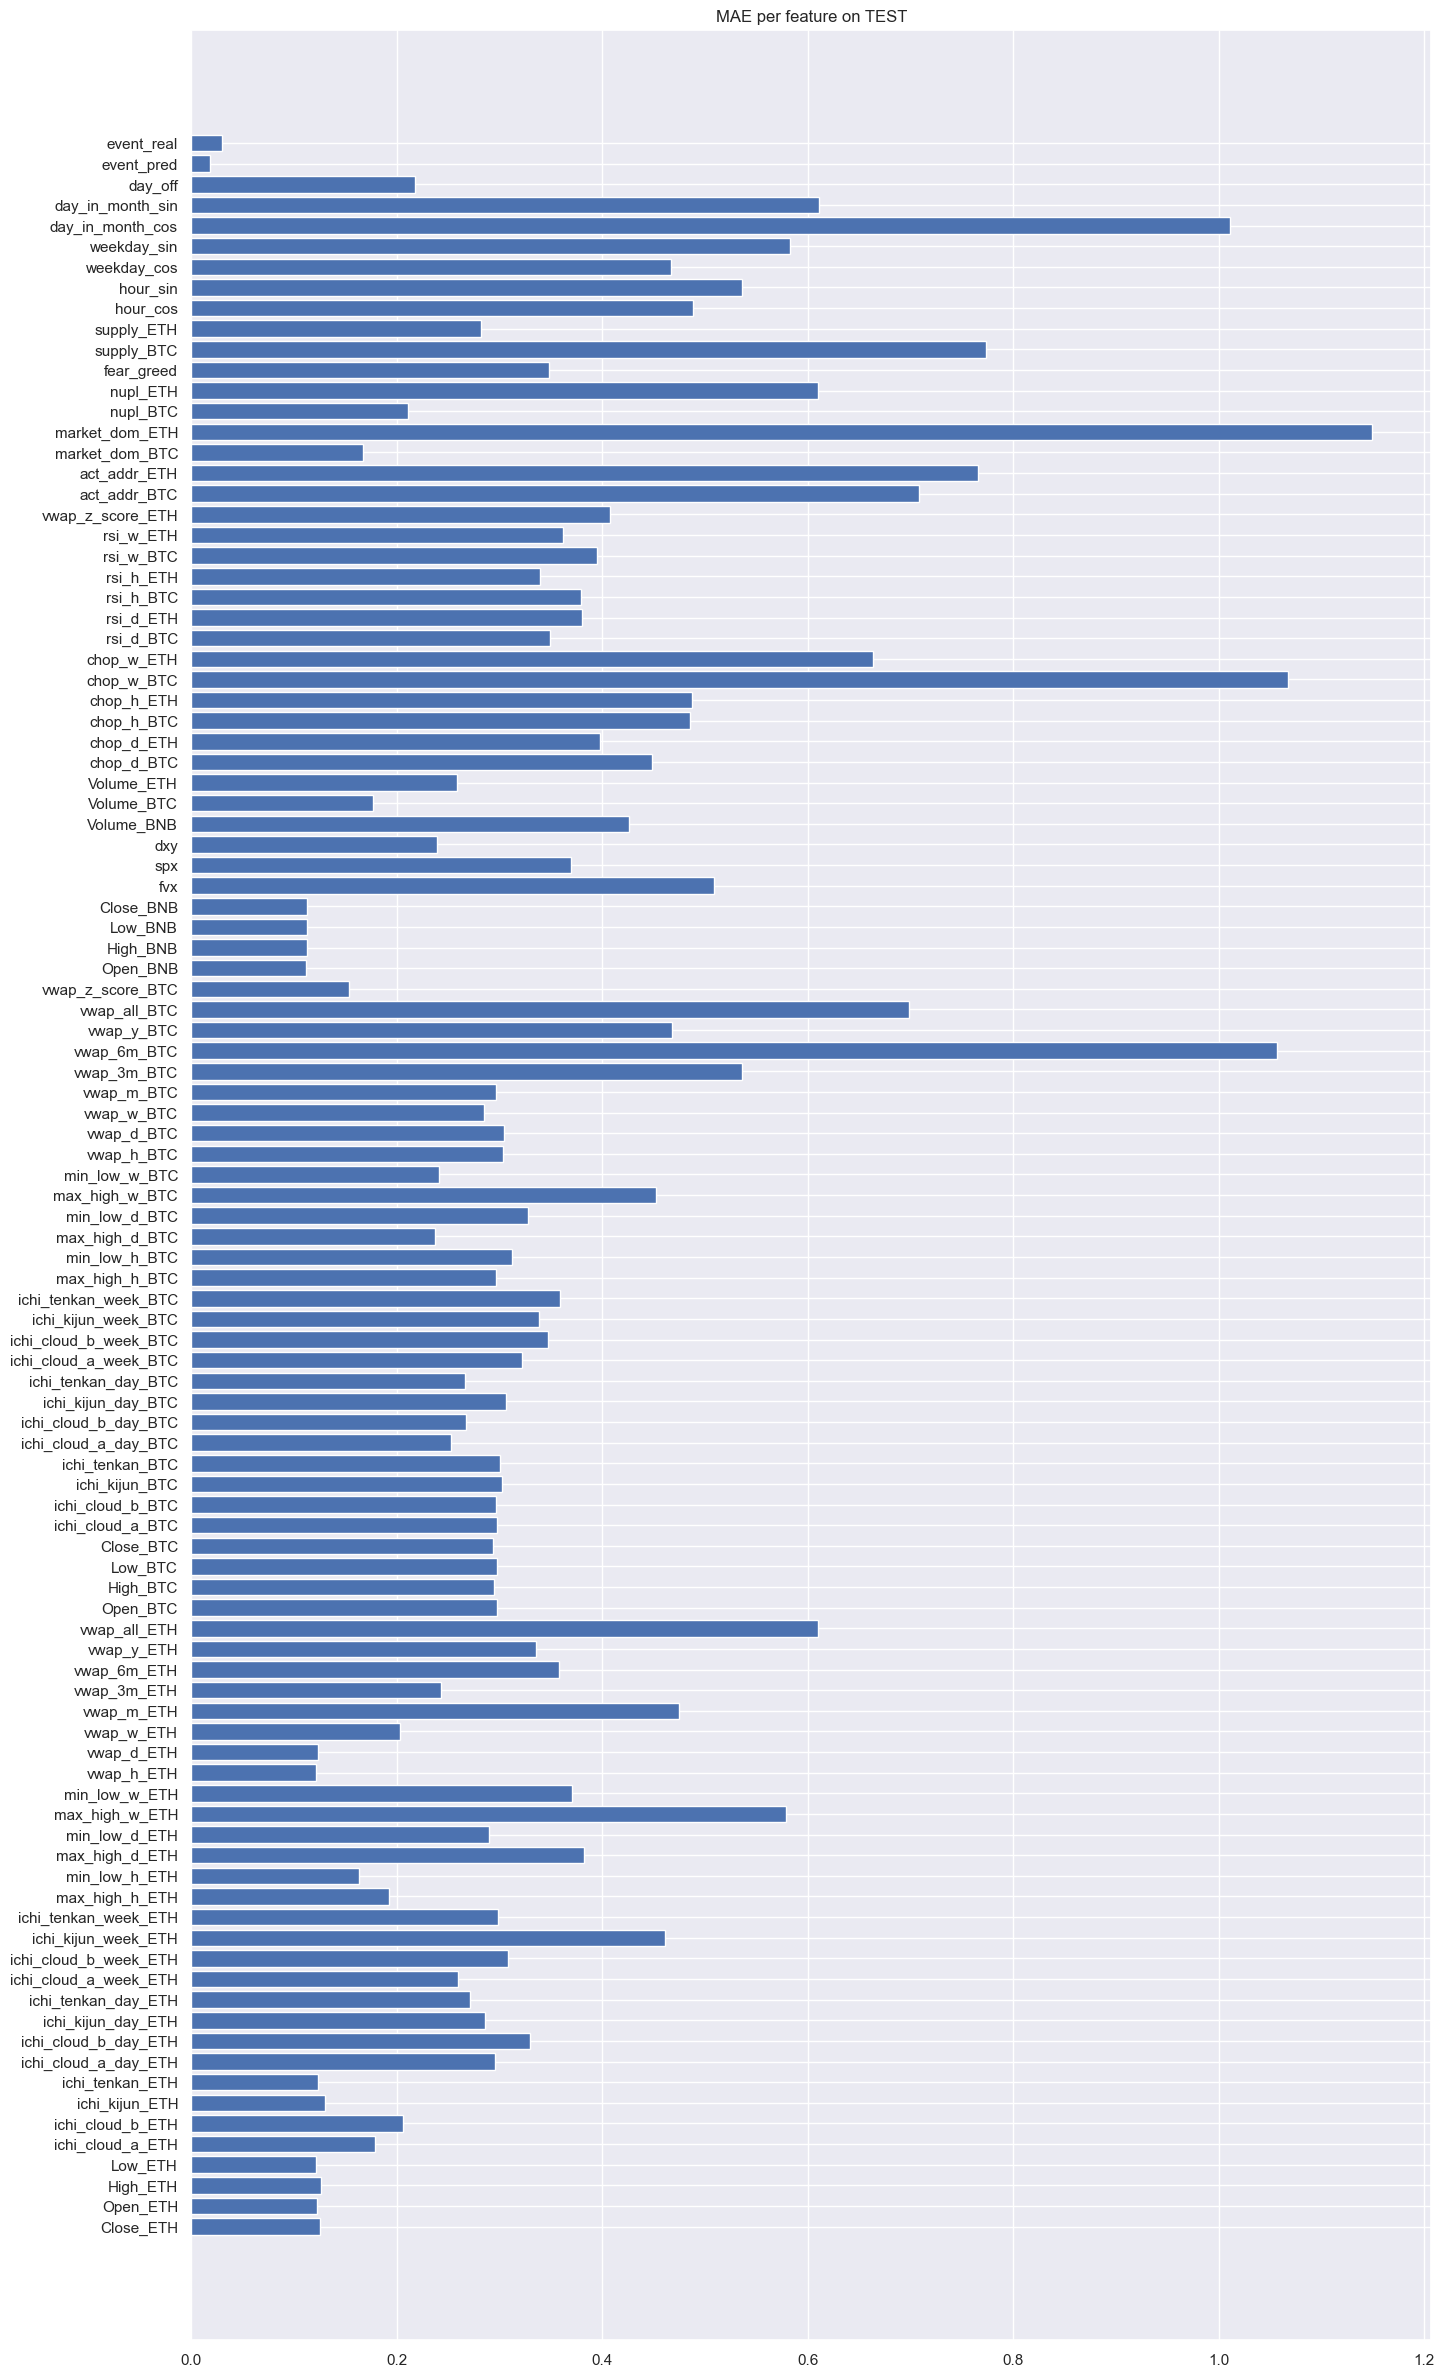

In [119]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [120]:
df_mae_ae_test_feat.values[0]

array([0.12518056, 0.1220592 , 0.12587644, 0.12141862, 0.17917322,
       0.20631477, 0.13051848, 0.12288948, 0.29522581, 0.32945691,
       0.2863784 , 0.27116776, 0.26009656, 0.30817532, 0.46136057,
       0.29848837, 0.19231842, 0.16355408, 0.38198889, 0.28958323,
       0.57875067, 0.37016059, 0.12121352, 0.12320557, 0.20283996,
       0.47491964, 0.24349327, 0.35797066, 0.33521574, 0.61037608,
       0.29728721, 0.29502076, 0.29715971, 0.29366798, 0.29793914,
       0.29619198, 0.30253686, 0.30084216, 0.25256538, 0.26761279,
       0.30611062, 0.26678465, 0.32236043, 0.34768046, 0.33852106,
       0.35897056, 0.29625206, 0.31245471, 0.23724451, 0.32796652,
       0.45249888, 0.24124218, 0.30378448, 0.3041439 , 0.28461863,
       0.29705692, 0.53633814, 1.0567677 , 0.46791674, 0.69897093,
       0.15359254, 0.11121167, 0.11232276, 0.11213727, 0.11243355,
       0.5092768 , 0.36970853, 0.23917873, 0.42627399, 0.17720716,
       0.25871085, 0.44799696, 0.39804559, 0.4859462 , 0.48733

In [121]:
2/df_mae_ae_test_feat.values[0].sum()

0.05483636645698816

In [122]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.289100
1       TRAIN   Close_ETH  0.142181
2       TRAIN   Close_ETH  0.134945
3       TRAIN   Close_ETH  0.130211
4       TRAIN   Close_ETH  0.127143
...       ...         ...       ...
14683    TEST  event_real  0.028977
14684    TEST  event_real  0.028967
14685    TEST  event_real  0.028952
14686    TEST  event_real  0.028937
14687    TEST  event_real  0.028922

[14688 rows x 3 columns]

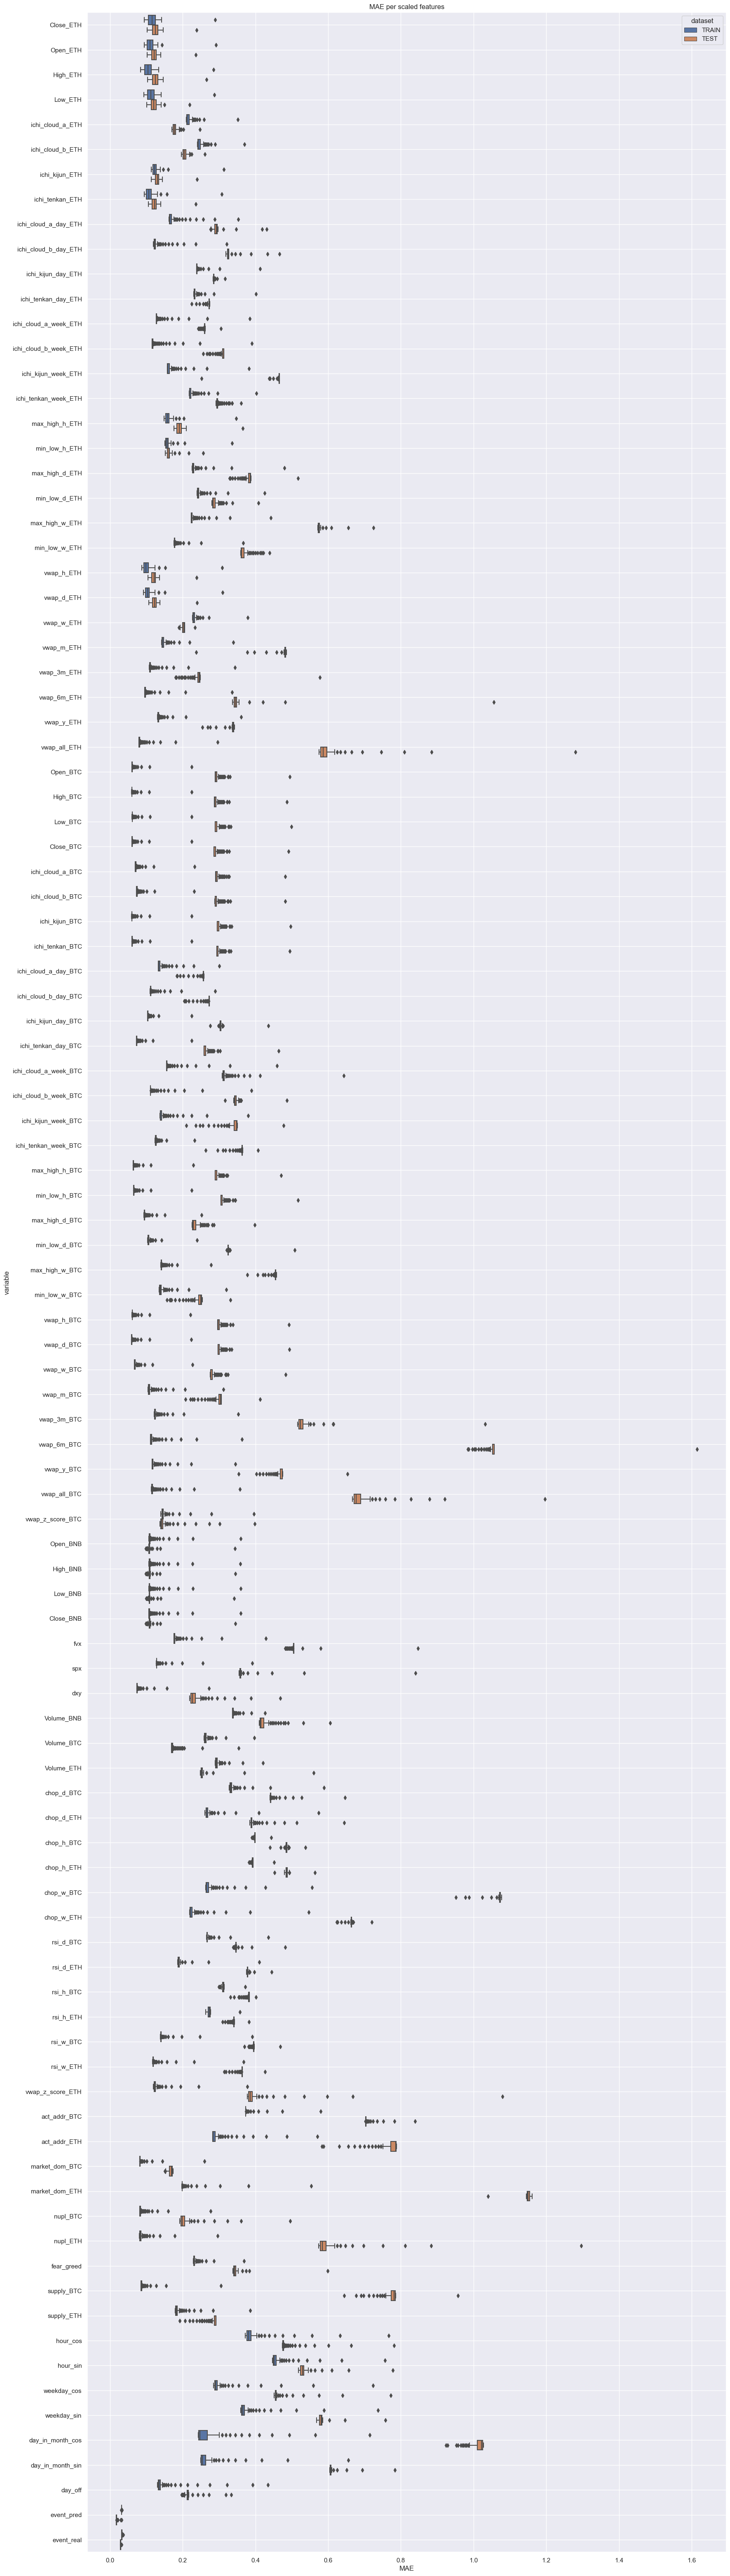

In [123]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [124]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(60507, 72, 102)
(60507, 72, 102)
(72, 102)
(15060, 72, 102)
(15060, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [125]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.033793  0.032216  0.028915  0.031950          0.183023   
0   0.039890  0.037600  0.036586  0.039319          0.076185   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.191665        0.036421         0.029018              0.058072   
0          0.094758        0.044695         0.035697              0.142487   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.036483  ...  0.221557  0.299470     0.141759     0.209989   
0              0.164941  ...  0.339305  0.387876     0.325751     0.491620   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.125780          0.116306  0.203685    0.998942    0.998505   
0          1.346024          0.484519  0.173119    0.267758    1.337536   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

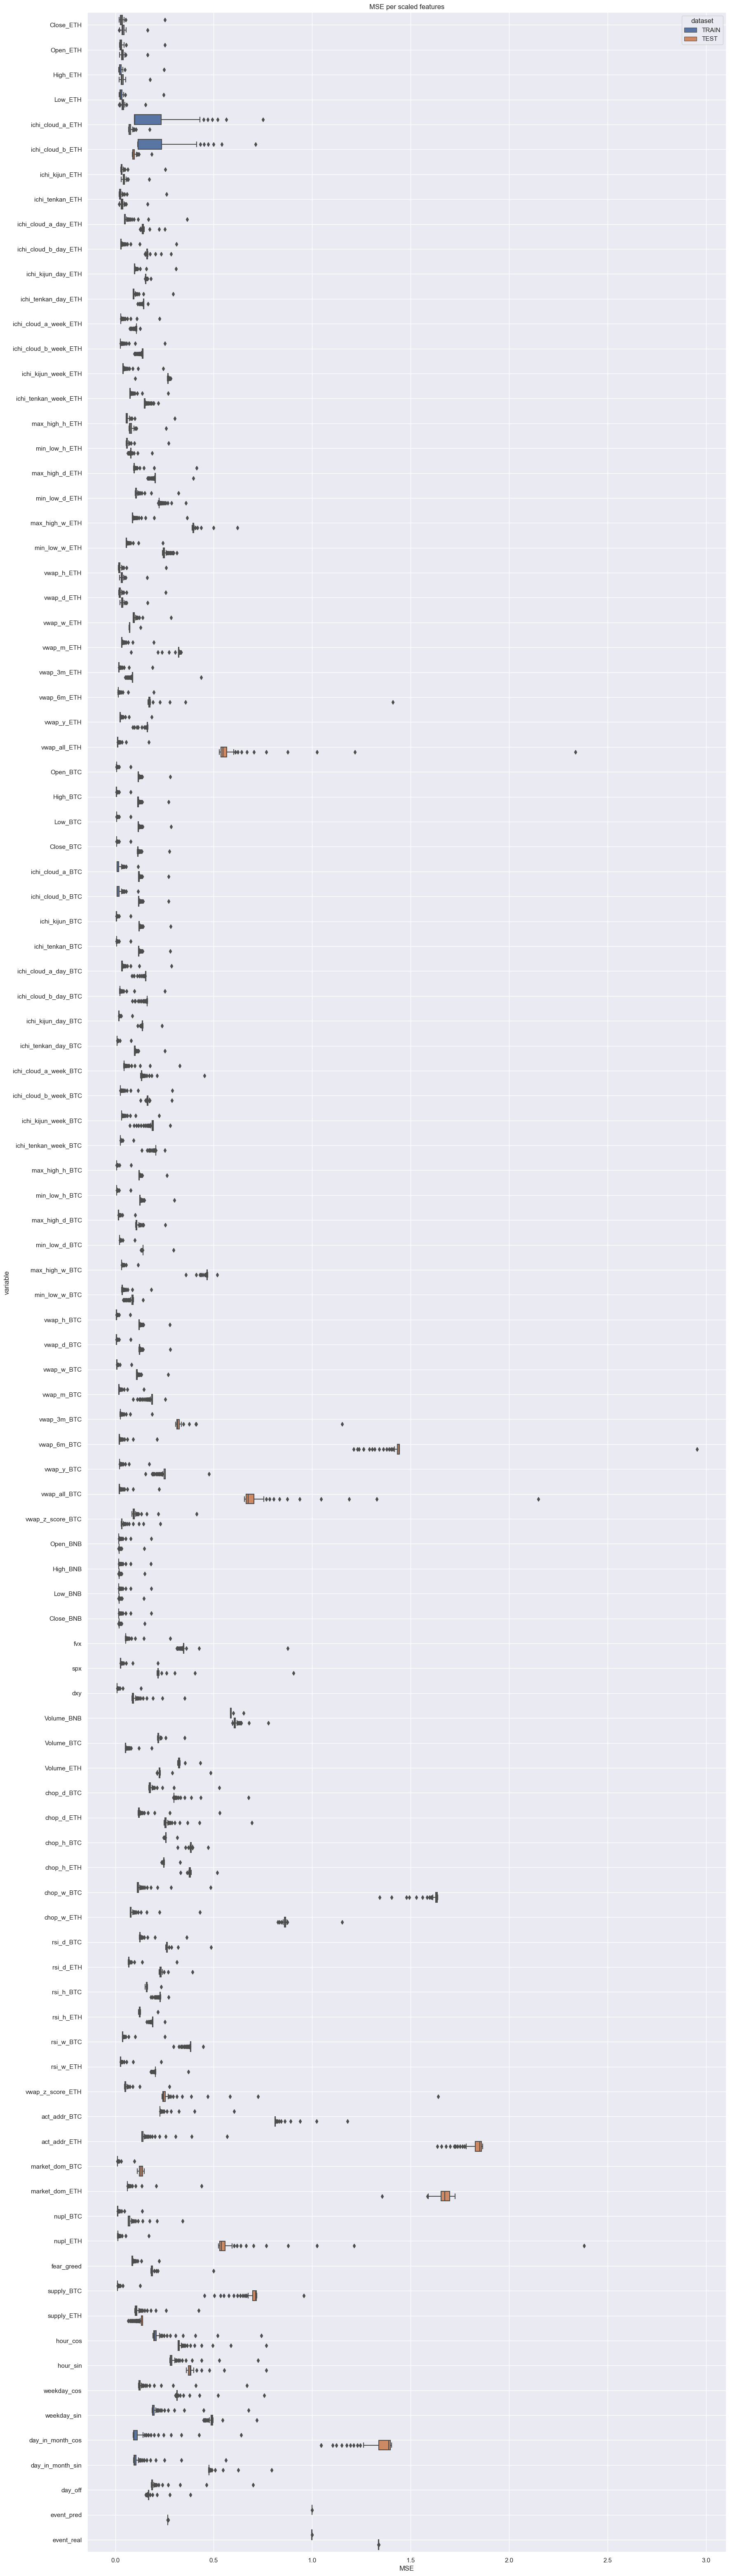

In [126]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

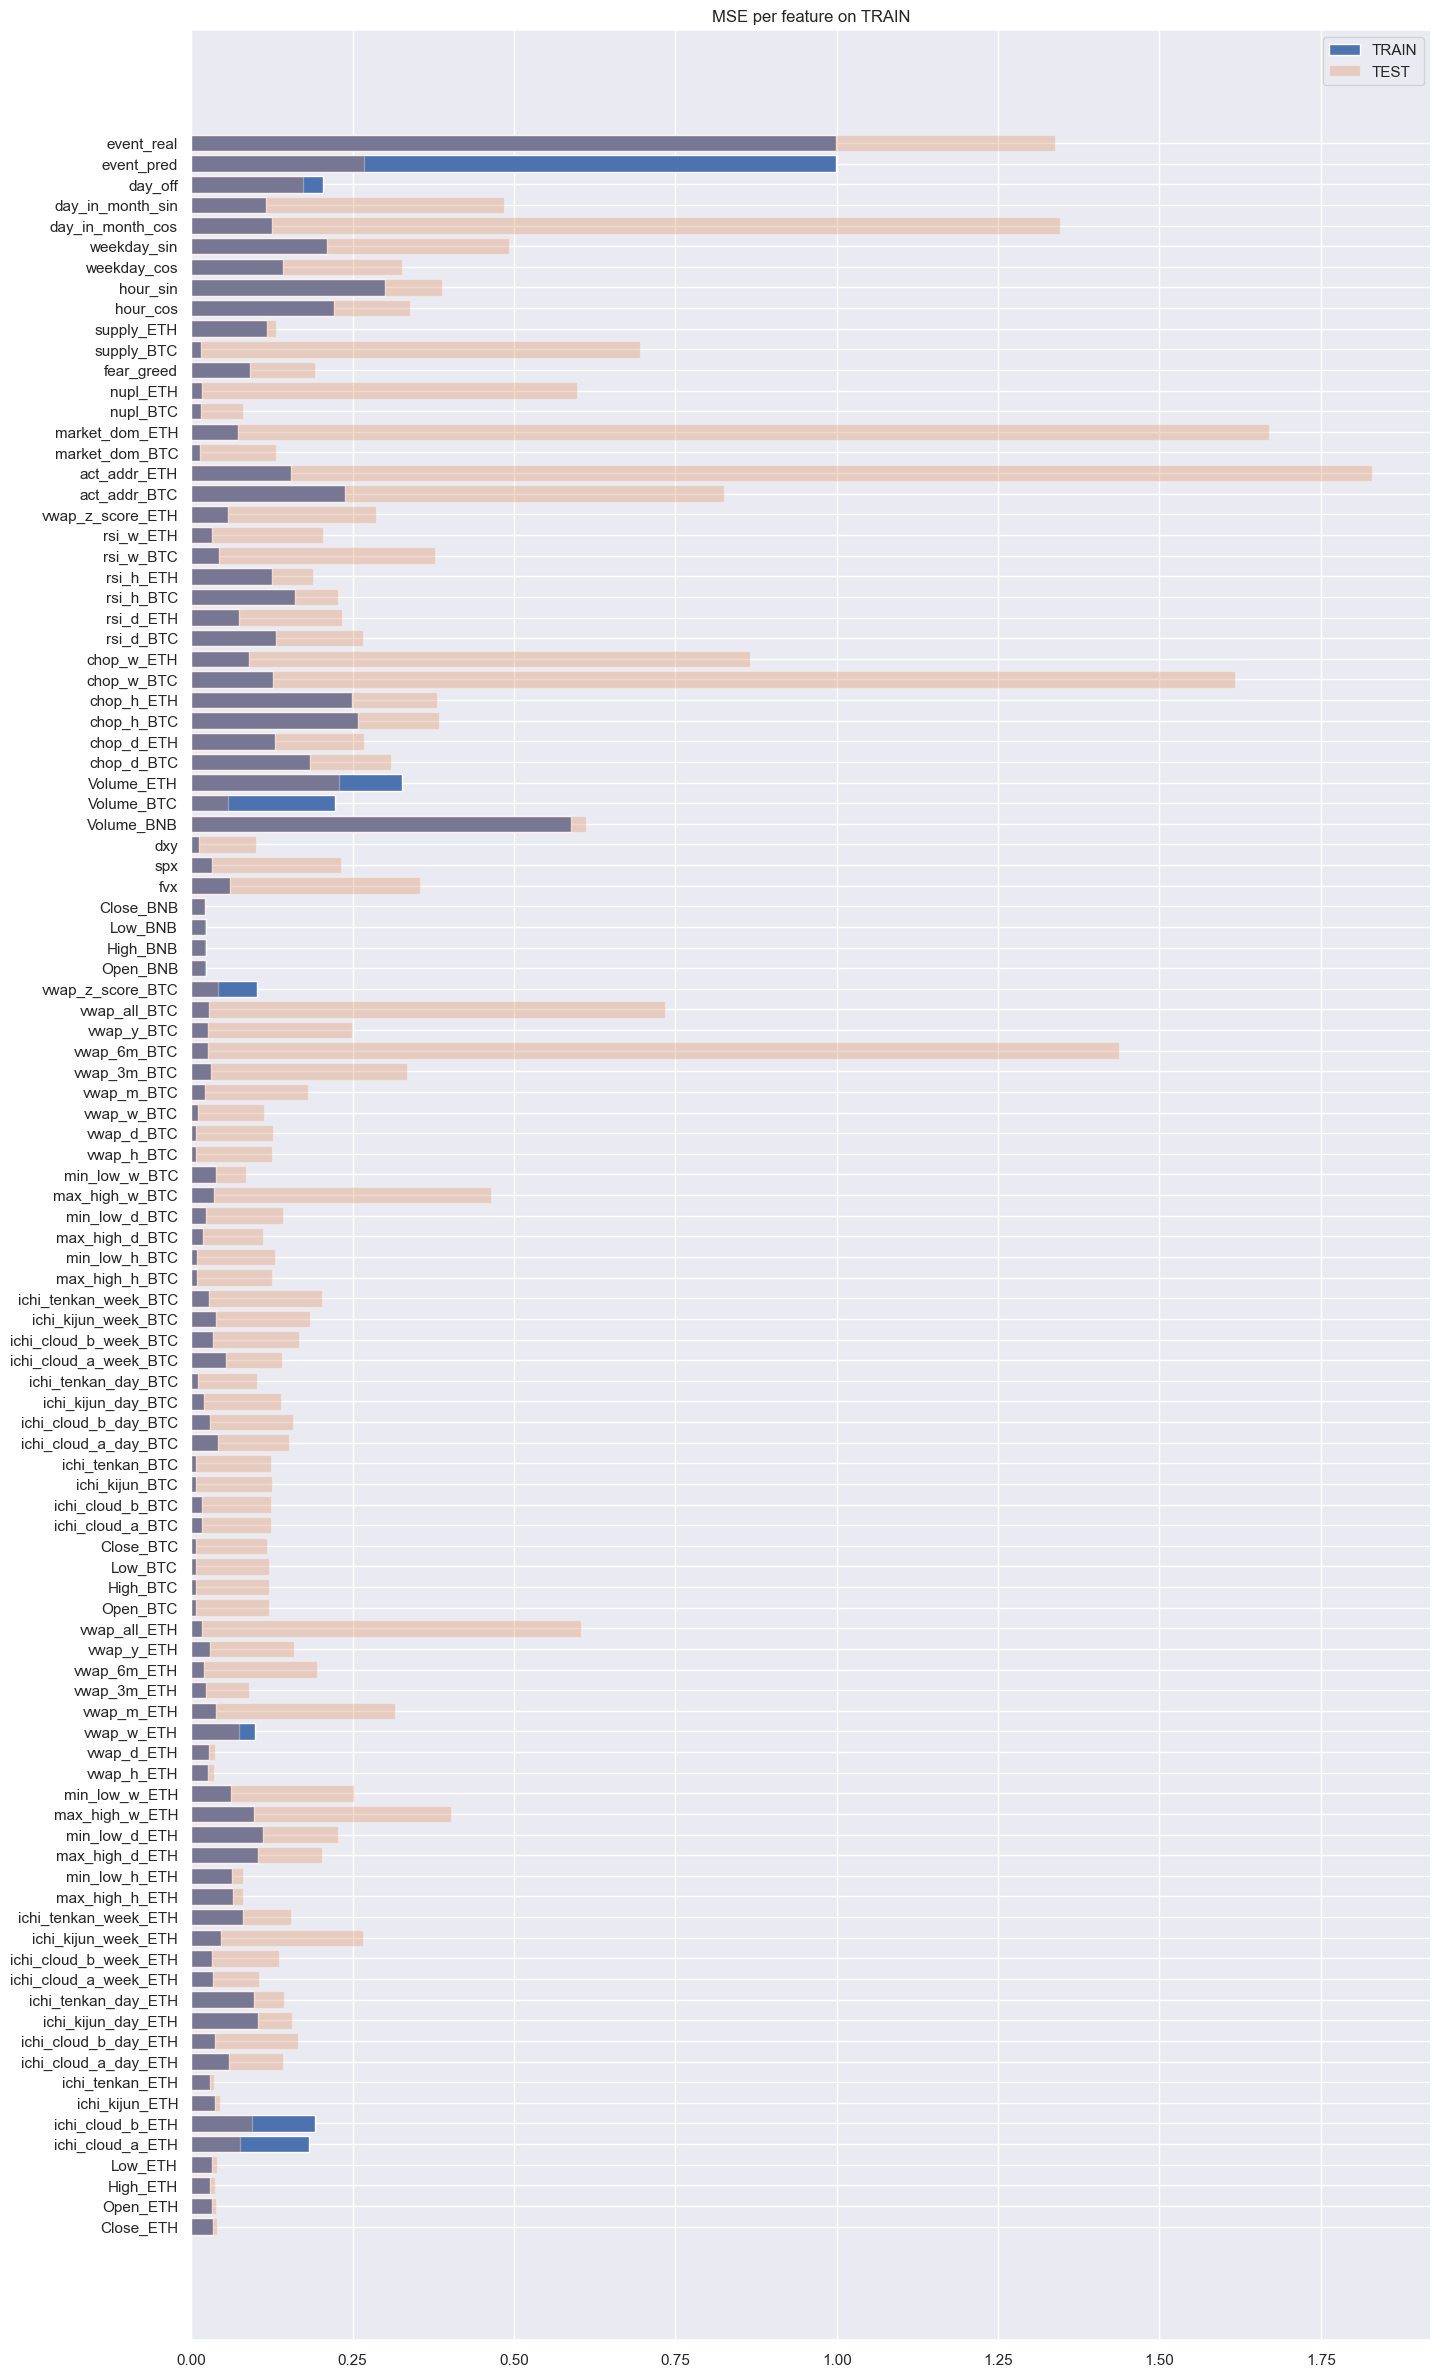

In [127]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [128]:
encoder_model.layers[3].get_weights()

[array([[ 0.06962472,  0.02972606, -0.47118756, ..., -0.29838762,
          0.09405127,  0.31182134],
        [ 0.00209357,  0.2961477 ,  0.14777929, ..., -0.16041654,
          0.02353206,  0.25230697],
        [-0.3381463 , -0.19640061, -0.56895846, ...,  0.09690192,
         -0.09368614, -0.09788348],
        ...,
        [ 0.15103564,  0.01376321,  0.06414024, ..., -0.18551944,
          0.23606396,  0.10026007],
        [-0.1961631 , -0.32009012,  0.05909443, ..., -0.28225803,
         -0.00361606,  0.16546562],
        [ 0.22092237, -0.1366064 , -0.11396622, ...,  0.09567602,
          0.33568782, -0.2266657 ]], dtype=float32),
 array([-0.21549372,  0.48455155, -0.08151349, -0.22530122,  0.12364948,
         0.14090727,  0.5204622 , -0.1340864 ,  0.42701587, -0.11187058,
         0.05845749, -0.55121505,  0.09081456, -0.27314922,  0.05466922,
         0.23616622], dtype=float32)]

## Prediction Models

### LSTM all features

In [129]:
X_train_sca.shape

(60507, 72, 102)

In [130]:
X_train_sca.shape[-1]

102

In [131]:
X_train_sca.shape[-2:]

(72, 102)

In [132]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [133]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [134]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1891/1891 [==============================] - 24s 13ms/step


(60507, 72, 16)

In [135]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

471/471 [==============================] - 6s 13ms/step


(15060, 72, 16)

In [136]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [137]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [138]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [139]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((60507, 72, 20), (15060, 72, 20))

#### Correlations

In [140]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



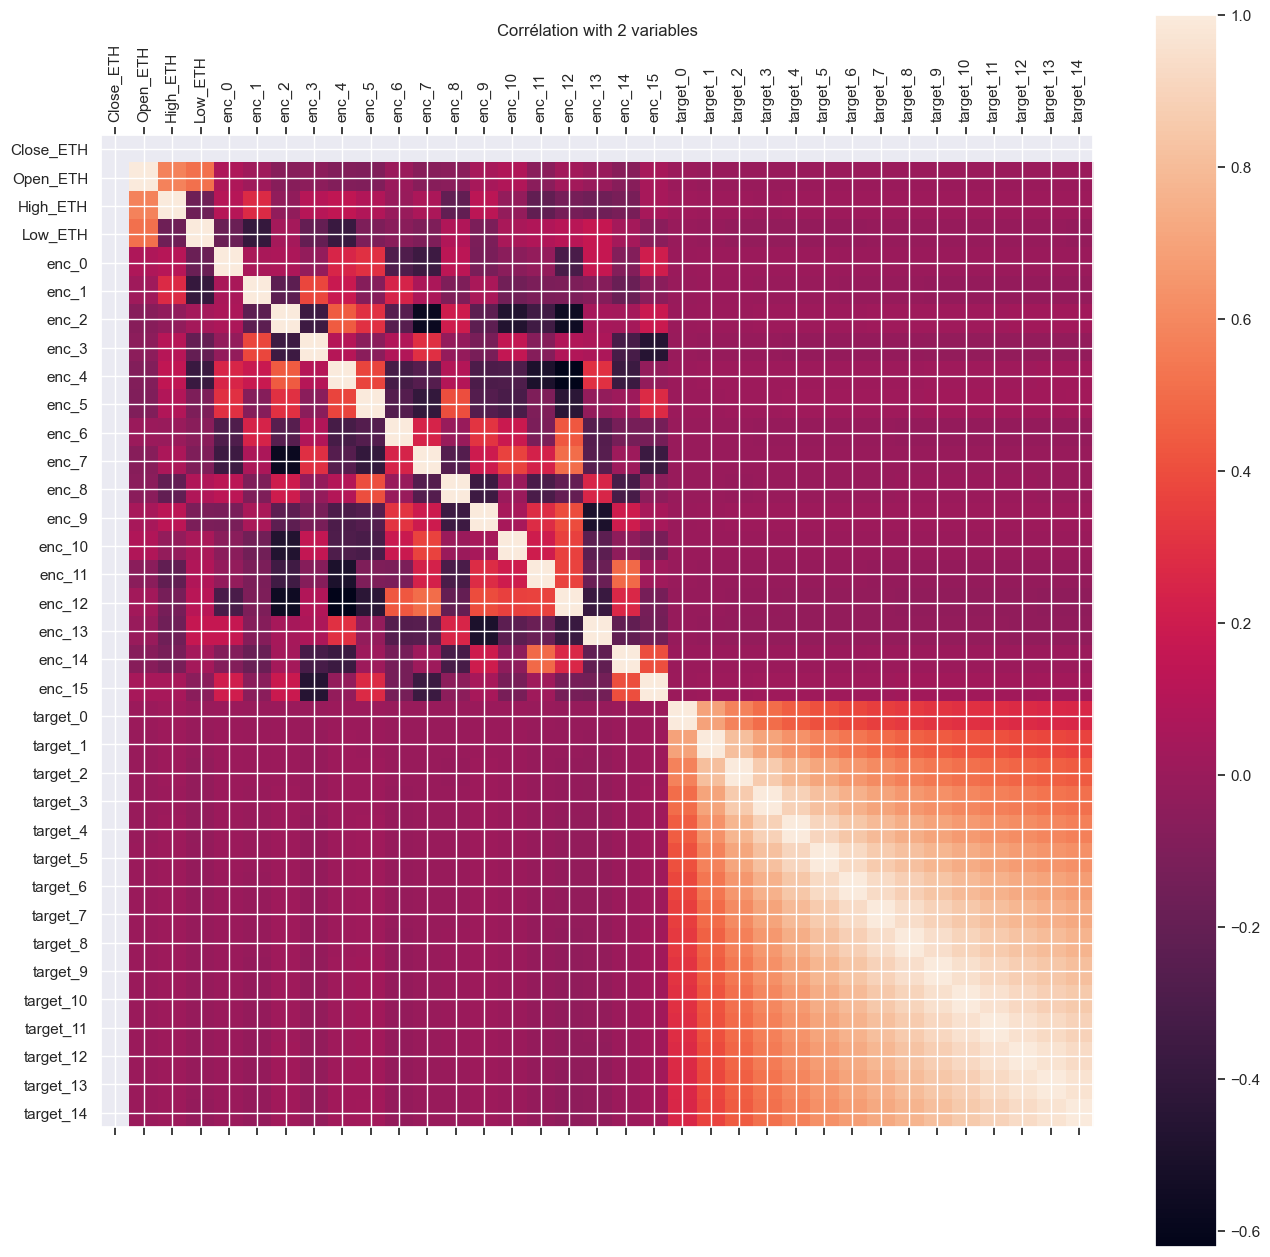

In [141]:
fig = plot_corr(corr_matrix_min)

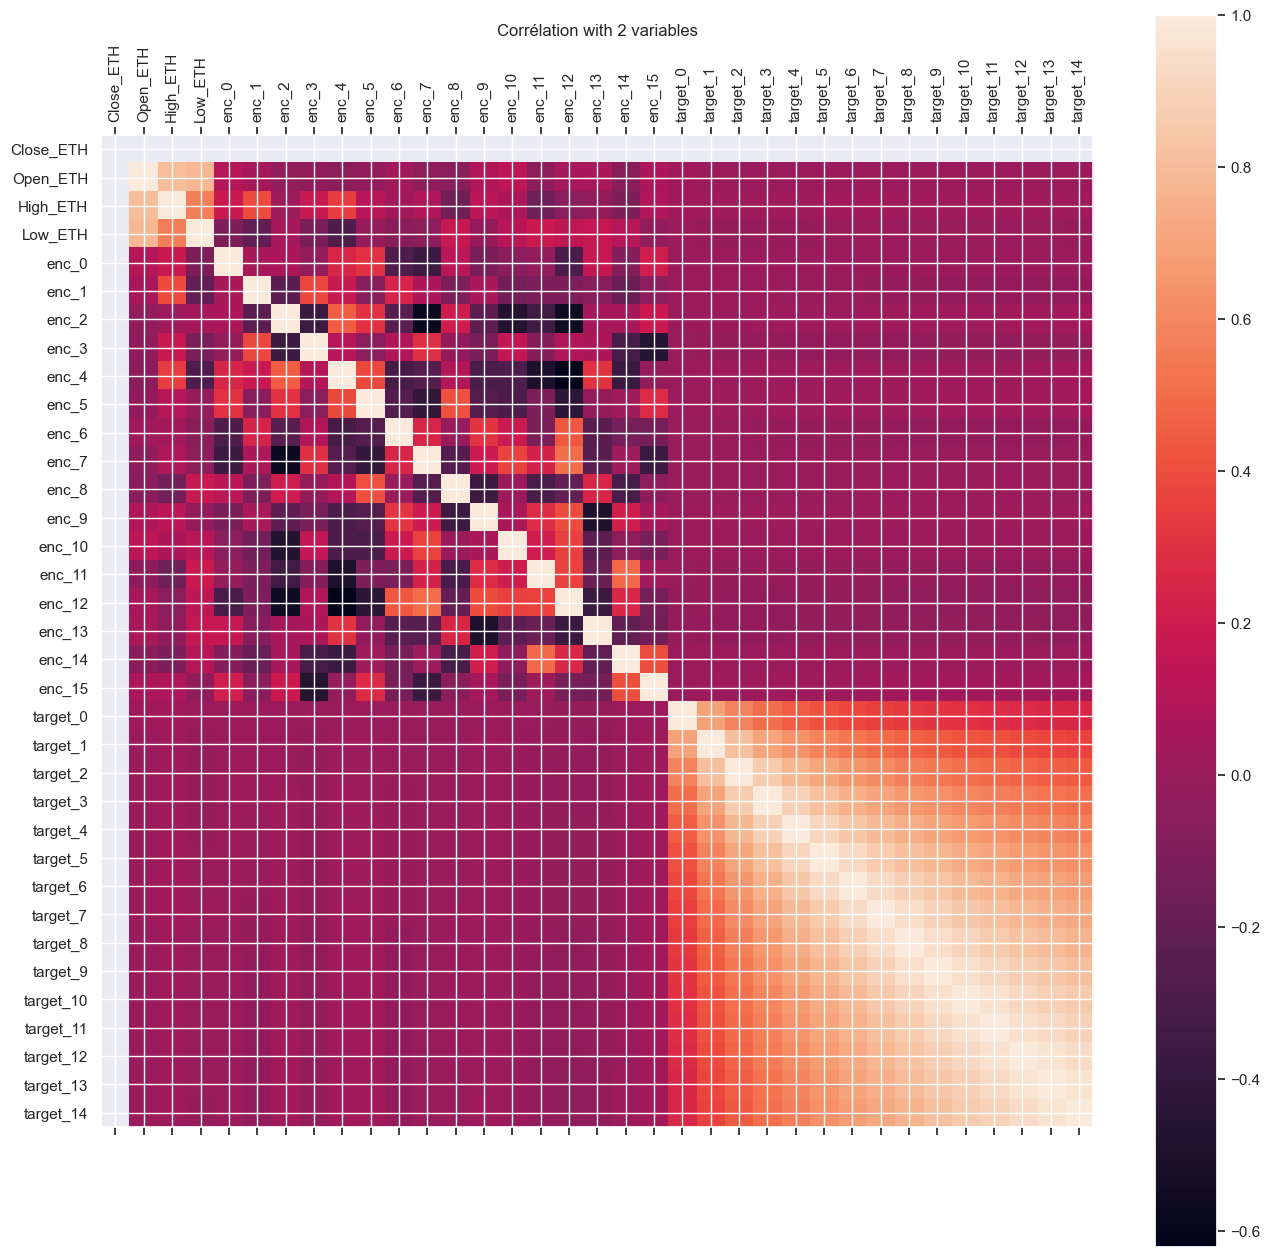

In [142]:
fig = plot_corr(corr_matrix_max) 

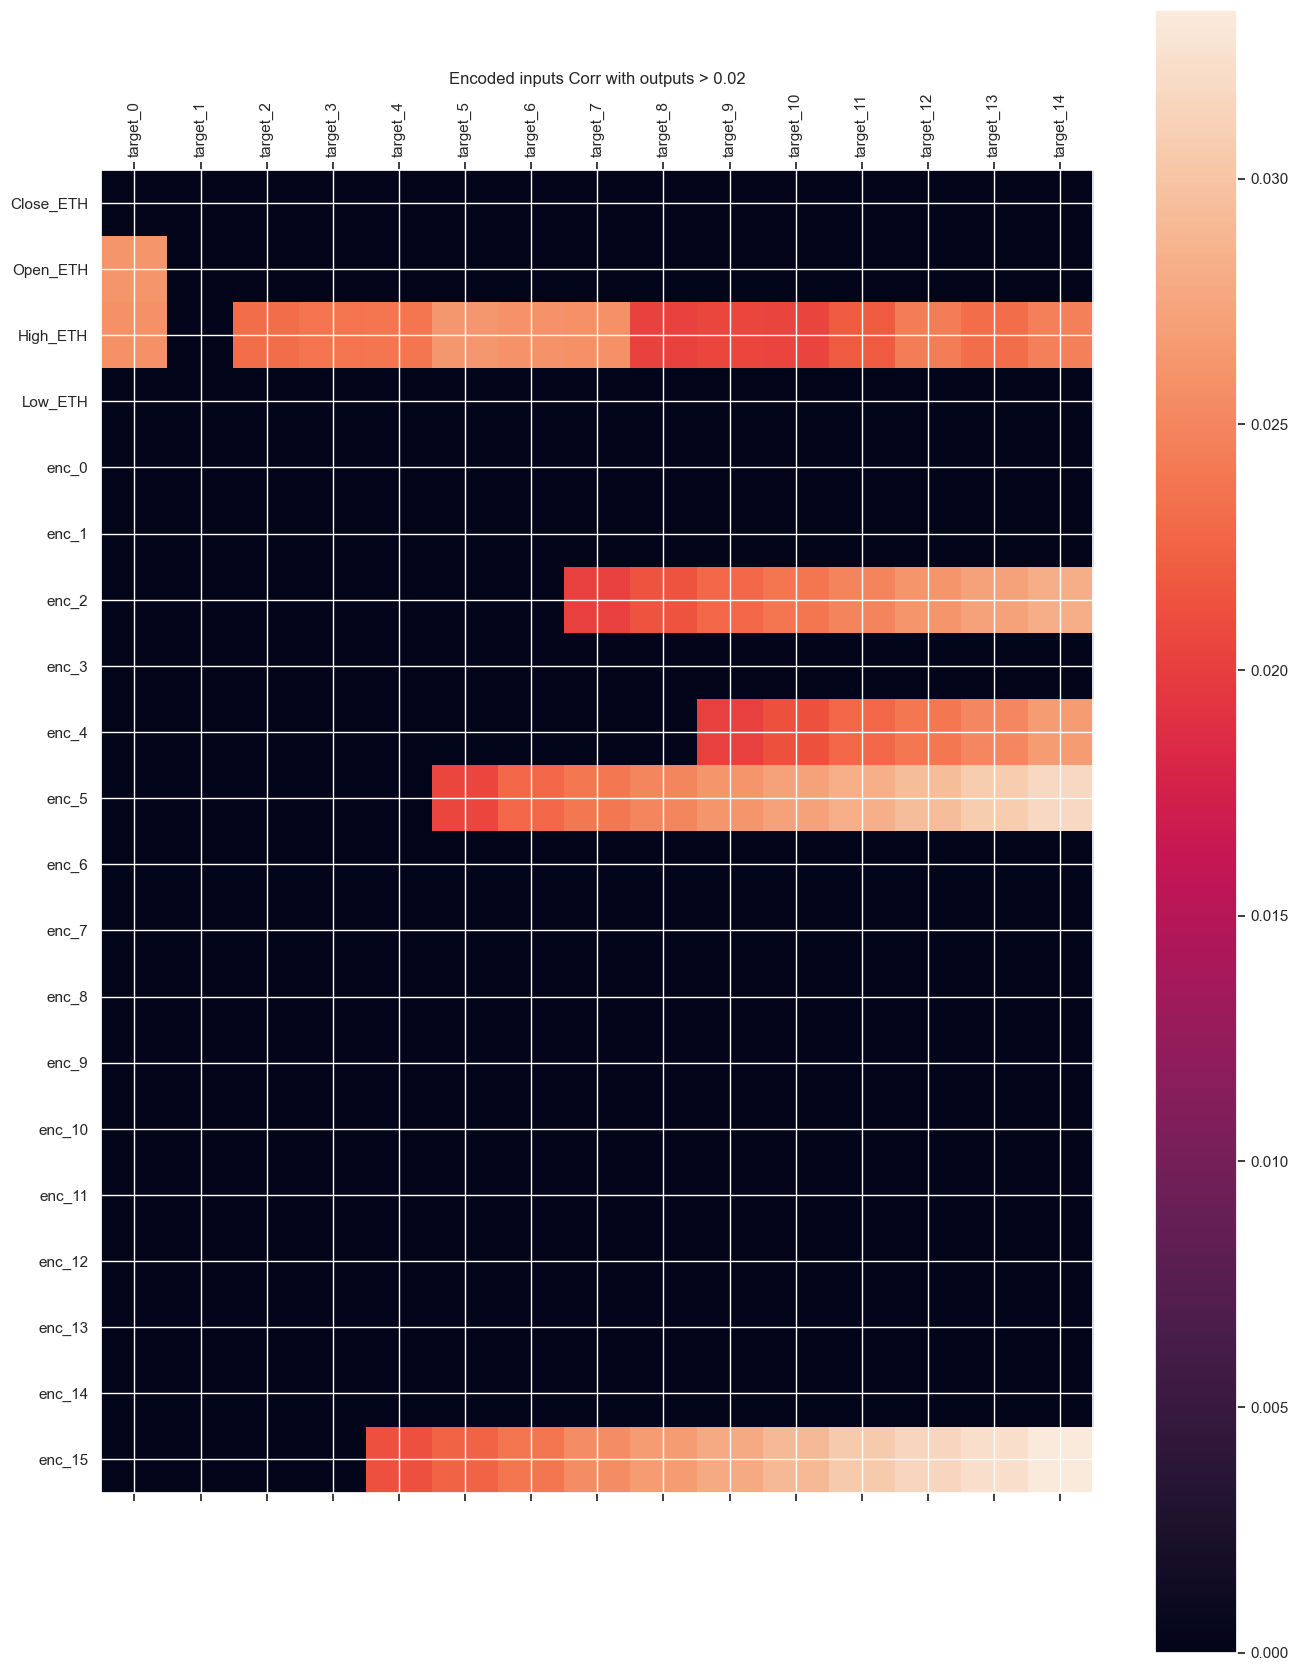

In [143]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

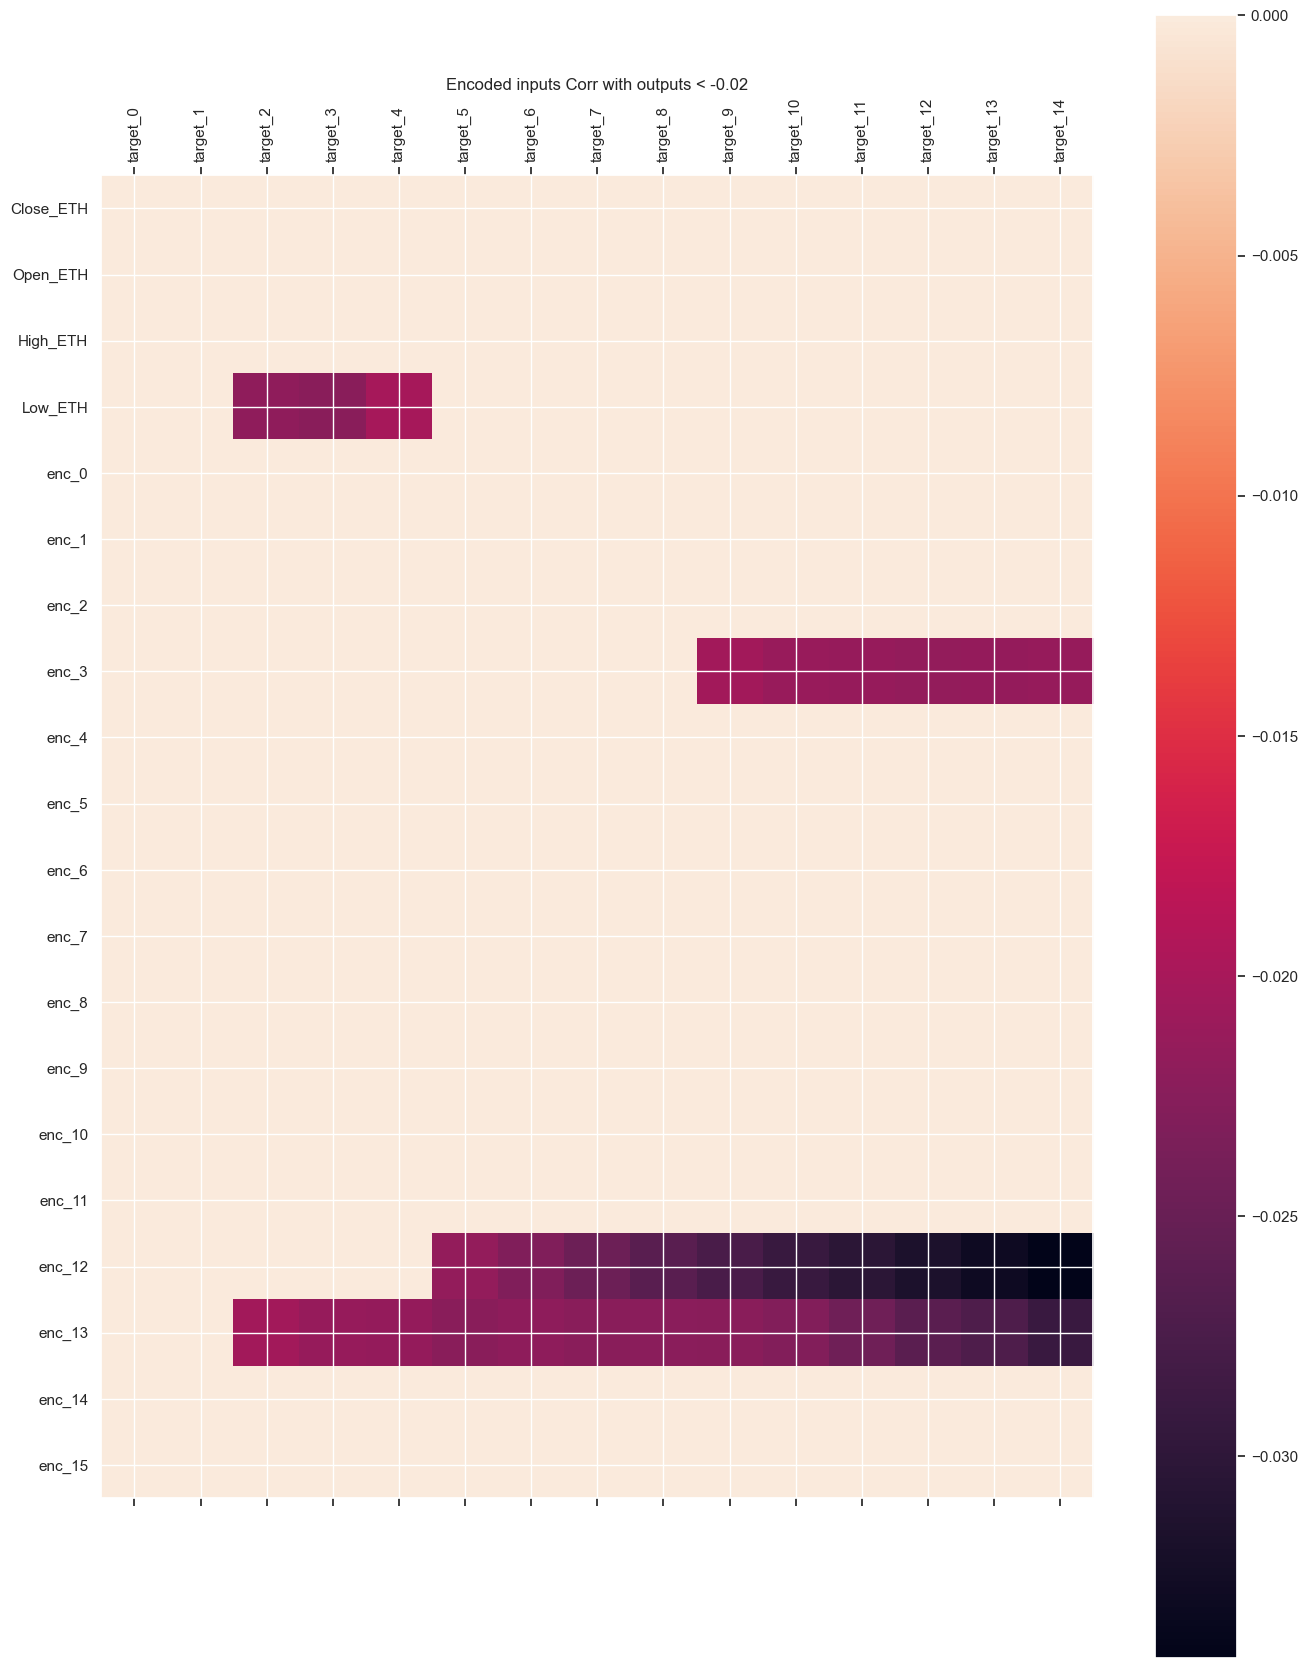

In [144]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [145]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [146]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [147]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [148]:
MODE_AUTO_SELECT

2

In [149]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[2, 3, 4, 5, 12, 13, 15]
nb encoded features:  7


In [150]:
X_train_.shape

(60507, 72, 20)

In [151]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  6,  7,  8,  9, 16, 17, 19])

In [152]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [153]:
X_train_.shape

(60507, 72, 11)

#### Train

In [154]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 20#30
patience = 0#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)
seed = 1
mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [128]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.15]: #[0.05, 0.15, 0.25]: #[0.1]:

            tf.keras.backend.clear_session()
            np.random.seed(seed)
            random.seed(seed)
            tf.random.set_seed(seed)
            optim = tf.keras.optimizers.legacy.Adam()
            #optim = tf.keras.optimizers.AdamW()
            if patience is not None:
                es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                verbose=1, patience=patience,
                                                restore_best_weights=True)
            # create model
            multi_step_model = tf.keras.models.Sequential()
            multi_step_model.add(
                tf.keras.layers.LSTM(
                    n_units,
                    return_sequences=False,
                    input_shape=X_train_.shape[-2:],
                    #kernel_regularizer=reg,
                    #bias_regularizer=reg,
                )
            )
            multi_step_model.add(tf.keras.layers.LayerNormalization())
            multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
            #multi_step_model.add(tf.keras.layers.BatchNormalization())
            multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
            # compile
            multi_step_model.compile(optimizer=optim, loss='mse')
            # fitting
            if patience == 0:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1,
                )
            else:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1, 
                    callbacks=[es],
                )
            # eval
            mse_curr = np.min(multi_step_history.history['val_loss'])
            print("MSE TEST : ", mse_curr)

            # plot MSE
            name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            plot_train_history(
                multi_step_history,
                f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                saveFolder="data",
            )

            # save the best
            if mse_curr_min == None:
                mse_curr_min = mse_curr
                n_units_min = n_units
                dropout_rate_min = dropout_rate

                print("Save model: ", path_mdl_predict_autoenc_lstm)
                multi_step_model.save(path_mdl_predict_autoenc_lstm)
            else:
                if mse_curr < mse_curr_min:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate
                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

else:
    
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    n_units = multi_step_model.layers[0].units#32
    dropout_rate = multi_step_model.layers[2].rate#0.25
    print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
    print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=128 / dropout= 0.15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               71680     
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 73871 (288.56 KB)
Trainable params: 73871 (288.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

In [155]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.15


In [156]:
np.min(y_train)

0.925613296000411

In [157]:
np.max(y_train)

1.0749270774292548

#### Results

##### Save mdl

In [158]:
X_train_.shape

(60507, 72, 11)

##### Predict

In [159]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

471/471 [==============================] - 6s 13ms/step


##### Plots

In [160]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(60510,)
(60510,)


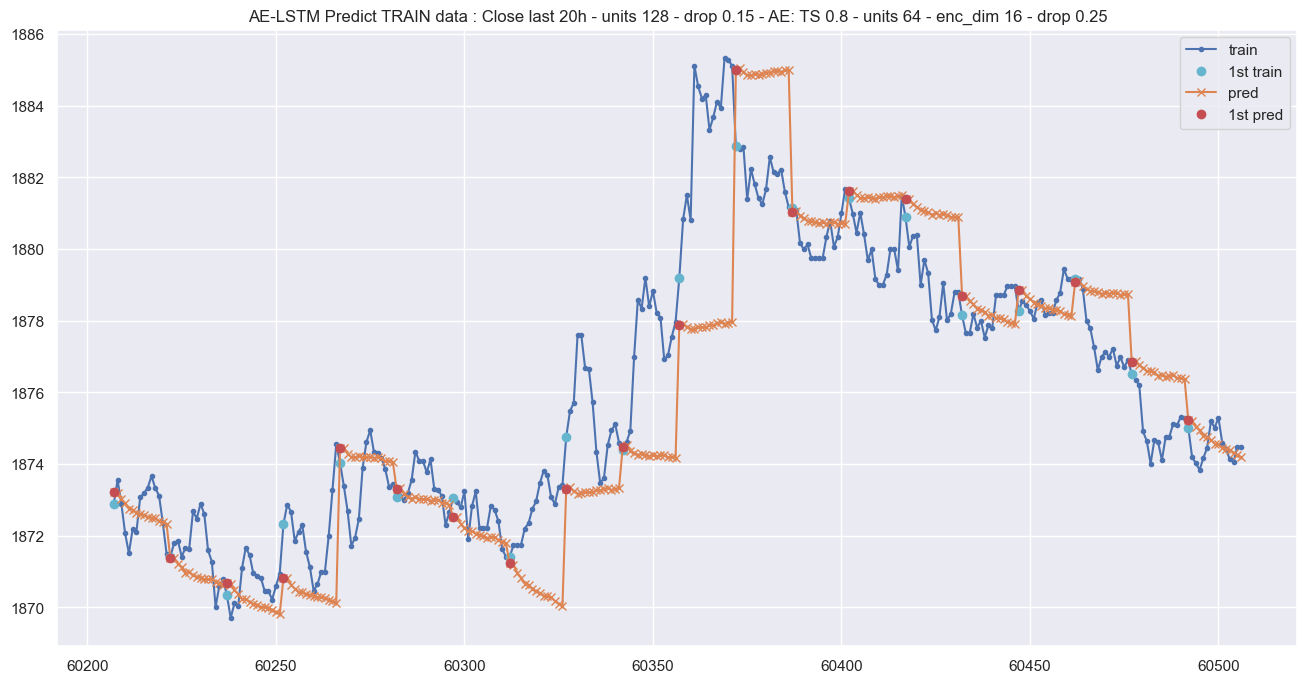

In [161]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

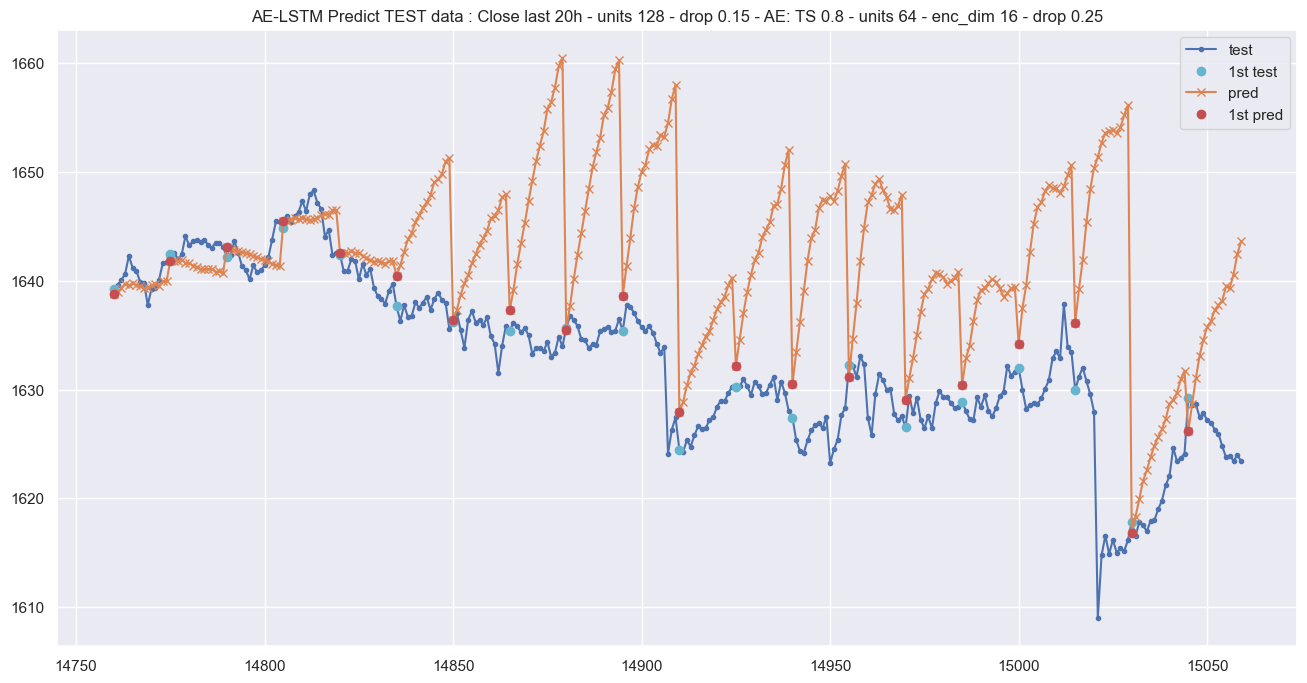

In [162]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

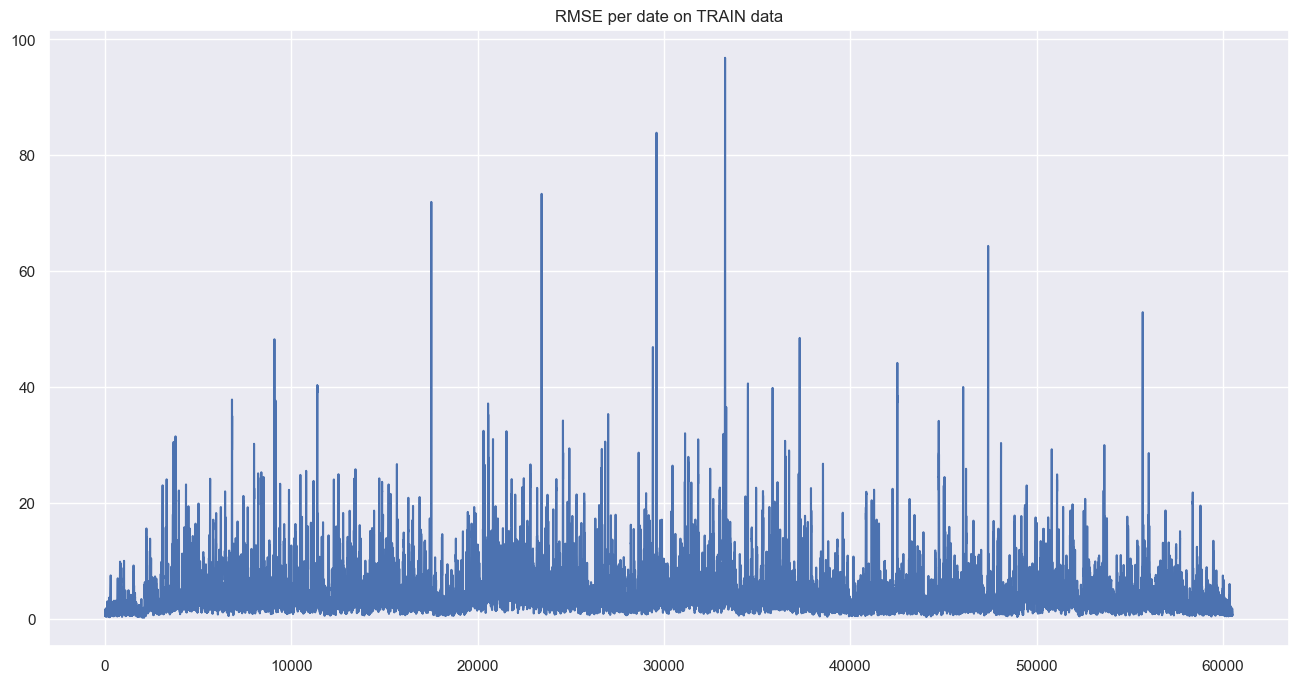

In [163]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

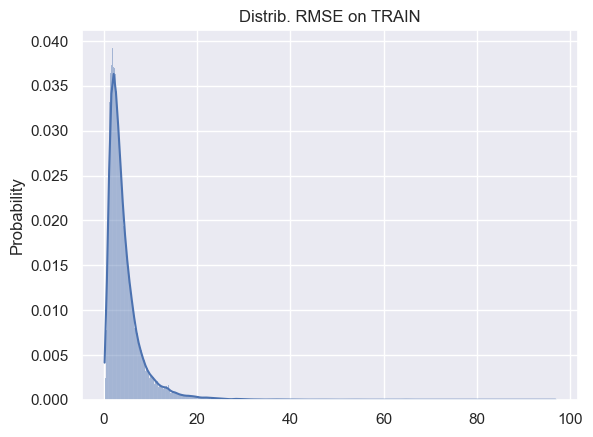

In [164]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.46')

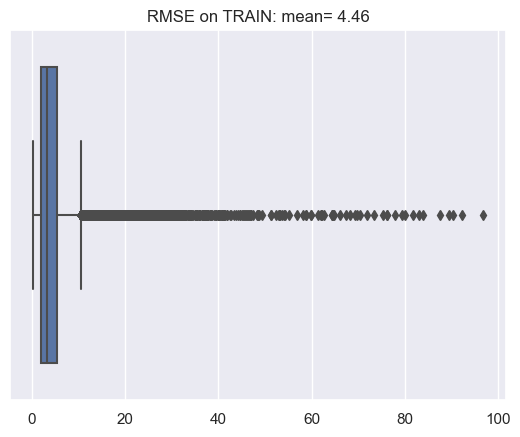

In [165]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

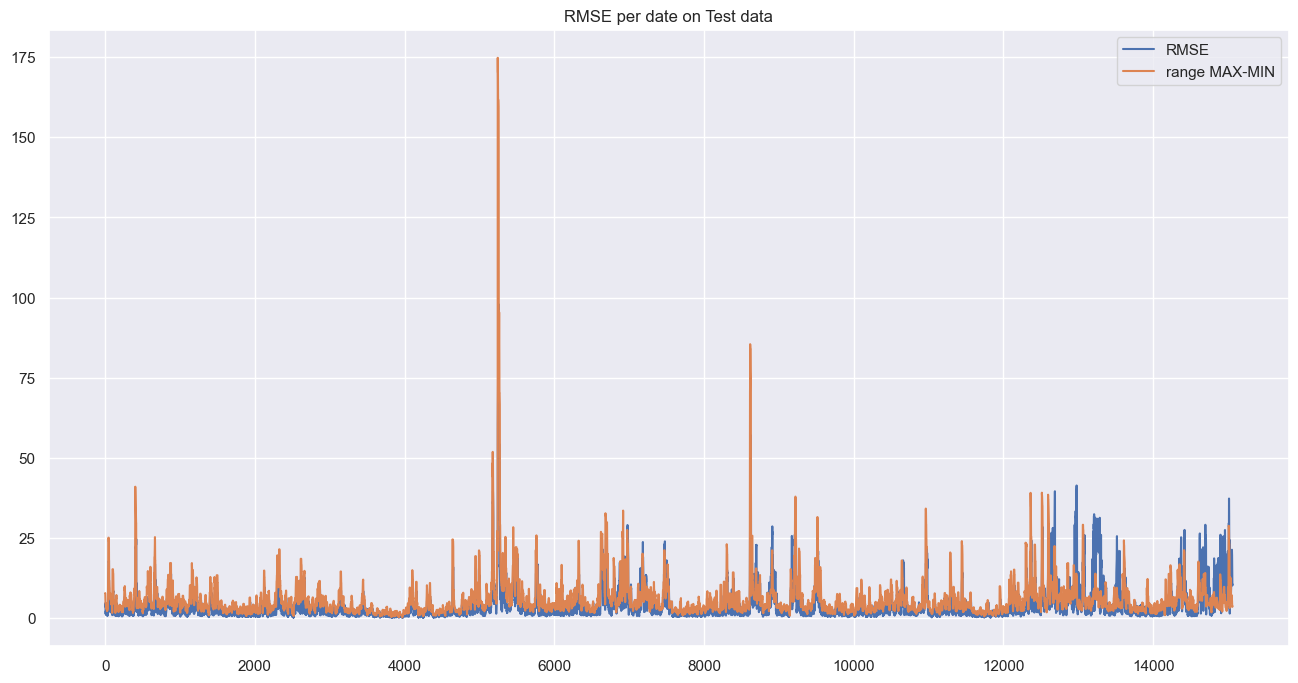

In [166]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [167]:
np.mean(arr_range)

6.222401062416997

<AxesSubplot: ylabel='Probability'>

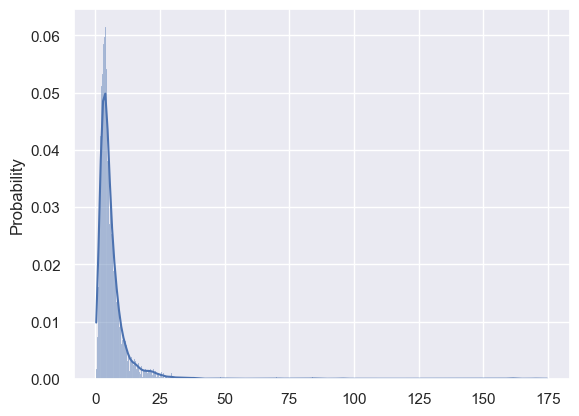

In [168]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [169]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

5.513963948479026

<AxesSubplot: ylabel='Probability'>

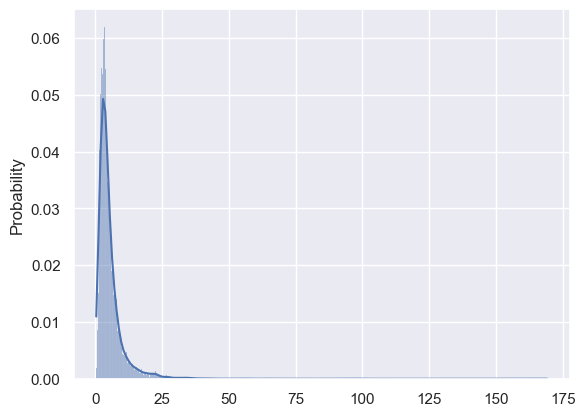

In [170]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

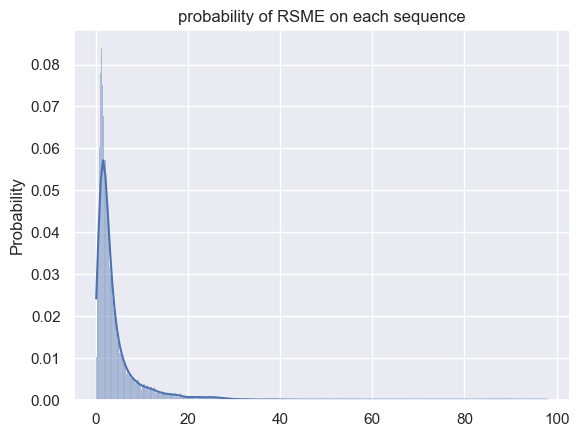

In [171]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 31.11200531208499)

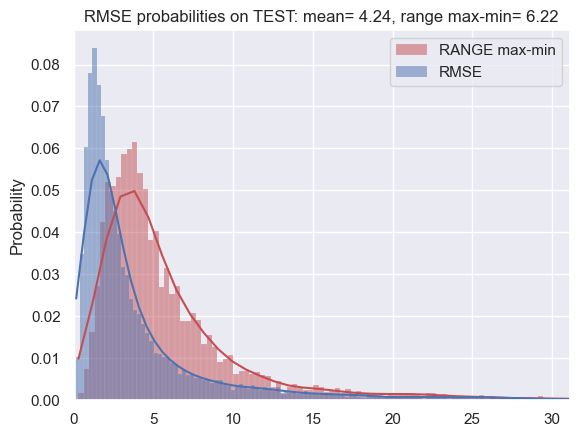

In [172]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 21.194060211650005)

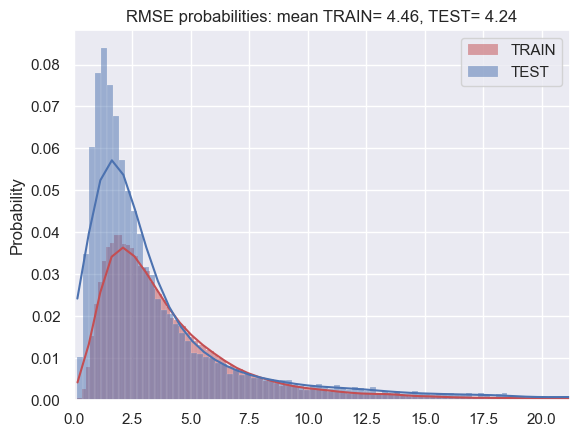

In [173]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 4.24')

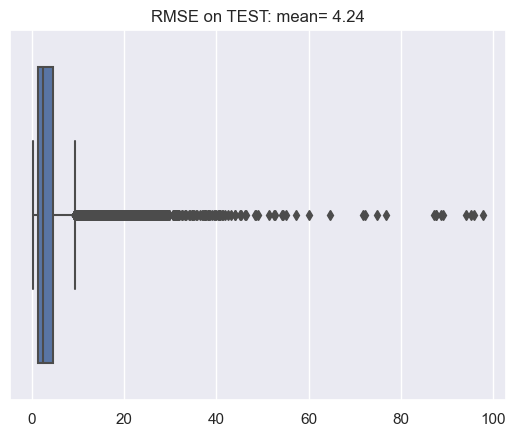

In [174]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [175]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1623.44 1623.95 1623.43 1621.38 1622.72 1622.88 1623.46 1622.88 1622.99
 1622.31 1620.38 1620.62 1622.53 1622.32 1623.8 ]
[1625.70956762 1628.31890196 1630.30431133 1633.3983829  1635.51620453
 1636.71198004 1637.07785599 1637.37094392 1637.5316196  1636.7464382
 1636.1712967  1634.87582483 1634.84852932 1635.19930562 1635.41670176]


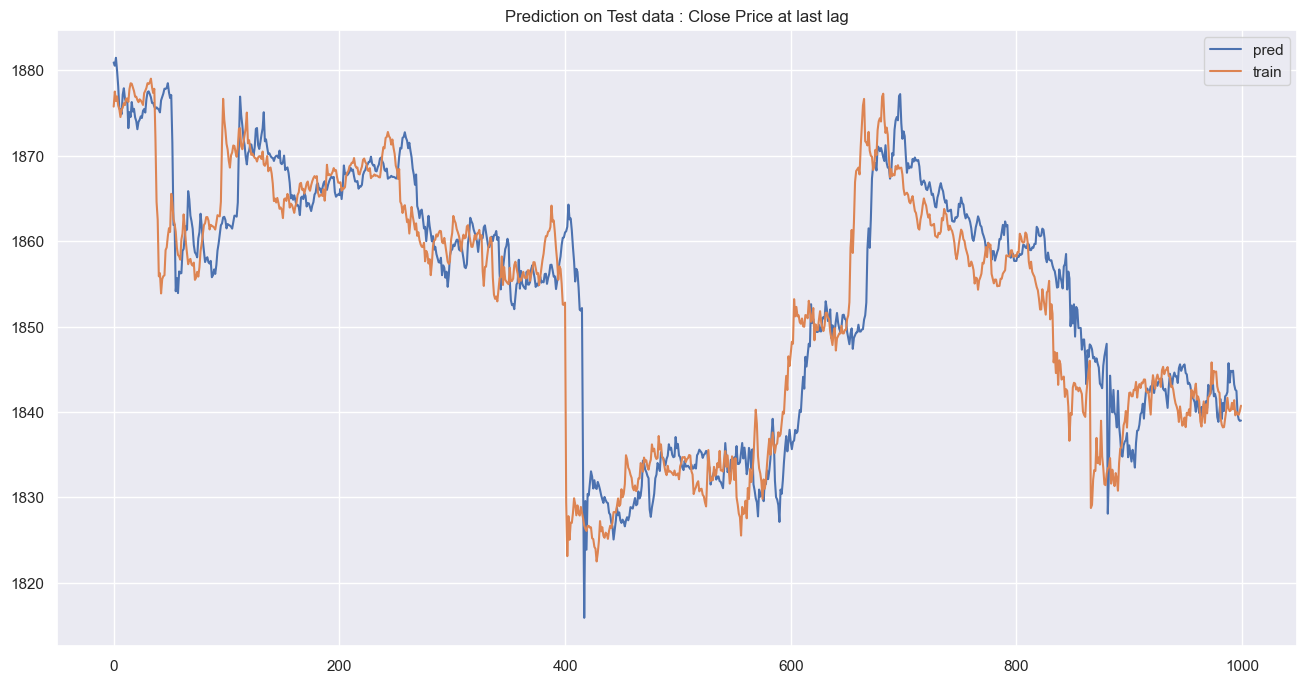

In [176]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

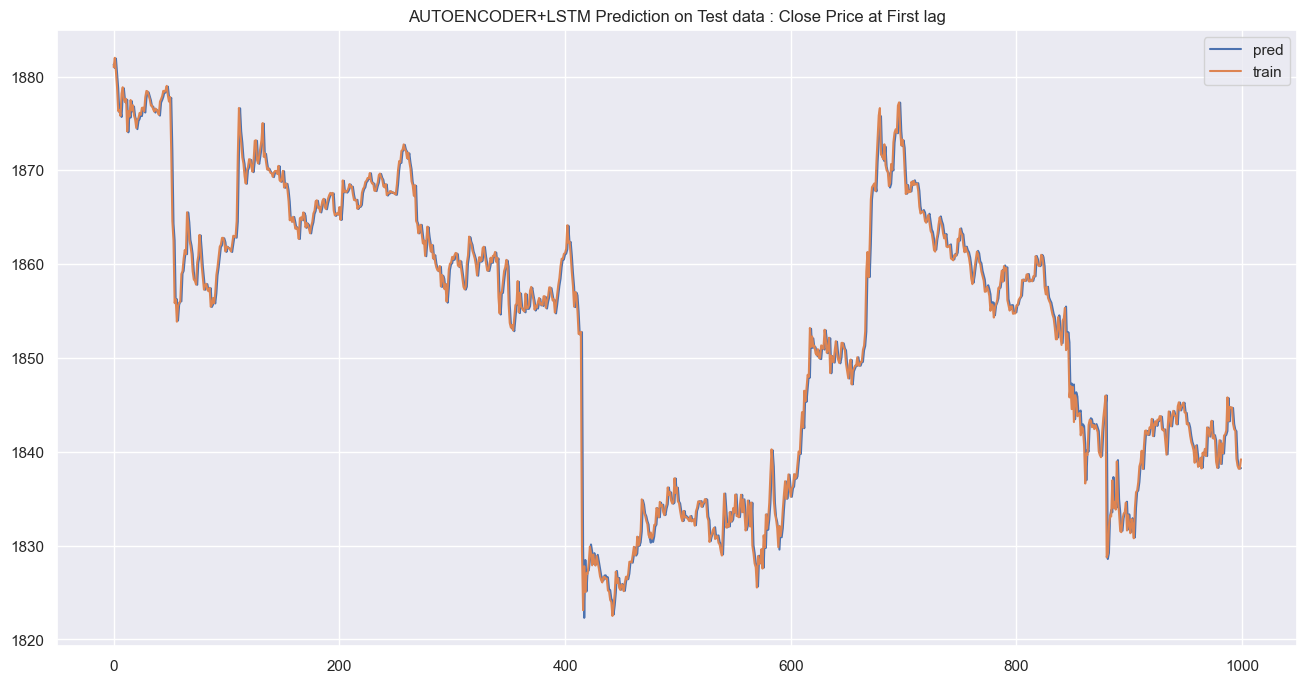

In [177]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

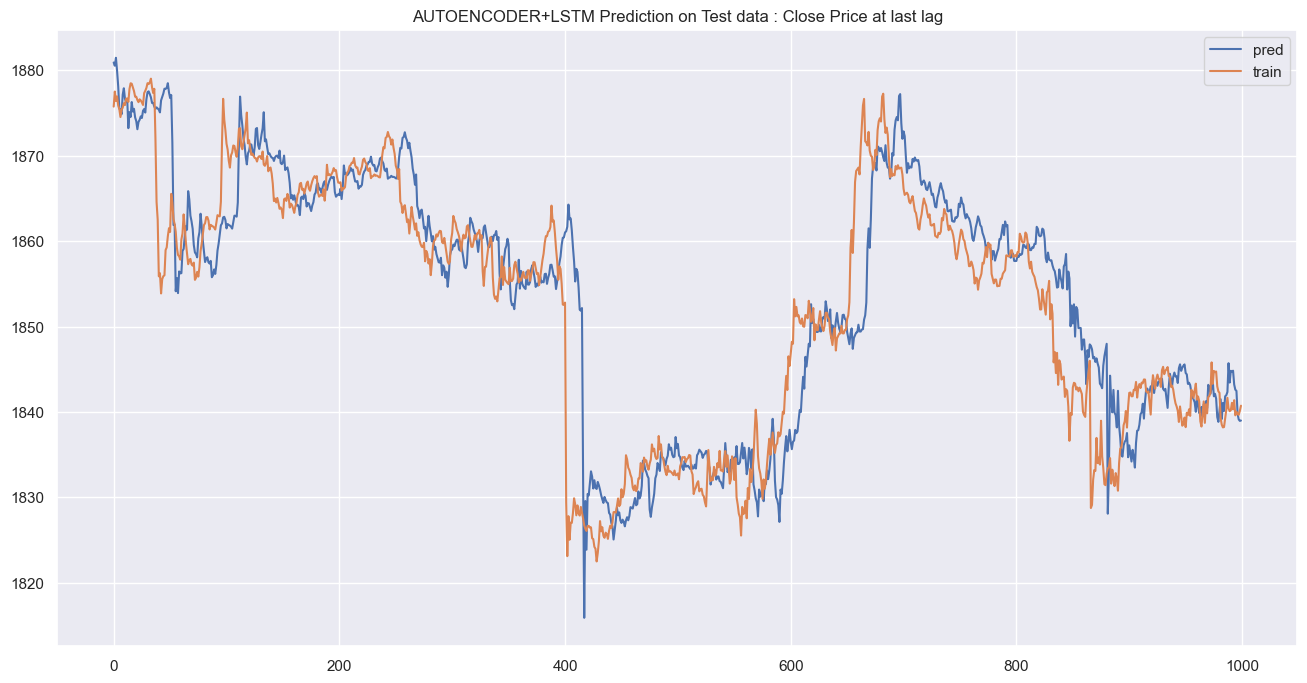

In [178]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [179]:
X_test_sca.shape

(15060, 72, 102)

In [180]:
df_feat["Close_ETH"].iloc[-1]

1622.58

In [181]:
df_feat["Close_ETH"].iloc[-1]

1622.58

In [182]:
len(list_i_enc_select)

7

In [183]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1628.59 1628.75 1628.65 1629.18 1630.04 1630.85 1632.88 1633.5  1632.89
 1637.83 1633.9  1633.49 1629.97 1631.16 1632.02 1630.76 1629.55 1627.95
 1609.   1614.76 1616.55 1614.88 1616.17 1615.   1615.38 1615.13 1616.16
 1617.83 1616.52 1617.82 1617.5  1616.95 1617.93 1617.96 1618.99 1619.77
 1621.2  1622.02 1624.64 1623.39 1623.71 1624.09 1629.24 1628.62 1628.64
 1627.46 1627.82 1627.21 1626.96 1626.31 1625.93 1624.79 1623.76 1623.91
 1623.44 1623.95 1623.43 1621.38 1622.72 1622.88 1623.46 1622.88 1622.99
 1622.31 1620.38 1620.62 1622.53 1622.32 1623.8  1624.19 1622.79 1622.58]
X_last[0,:,0] after divide by price:
[1.00370398 1.00380259 1.00374096 1.0040676  1.00459762 1.00509682
 1.00634792 1.00673002 1.00635408 1.00939861 1.00697654 1.00672386
 1.00455447 1.00528787 1.00581789 1.00504135 1.00429563 1.00330954
 0.99163061 0.99518051 0.9962837  0.99525447 0.9960495  0.99532843
 0.99556262 0.99540855 0.99604334 0.99707256 0.99626521 0.9970664
 0.99

In [184]:
X_last_encoded_sca.shape

(1, 72, 16)

In [185]:
list_i_enc_select

[2, 3, 4, 5, 12, 13, 15]

In [186]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 7)

In [187]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [188]:
X_train_.shape

(60507, 72, 11)

In [189]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
75736  1695252000000   1622.53   1622.78  1622.32    1622.32    121.5167   
75737  1695252300000   1622.32   1623.80  1622.32    1623.80    177.0394   
75738  1695252600000   1623.79   1624.30  1623.21    1624.19    312.3773   
75739  1695252900000   1624.18   1624.19  1622.56    1622.79    224.1724   
75740  1695253200000   1622.79   1623.13  1622.57    1622.58     84.5111   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1739.640127       1739.186414   
1      2023-01-01 00:05:00       1739.640127       1739.186414   
2      2023-01-01 00:10:00       1739.640127       1739.186414   
3      2023-01-01 00:15:00       1739.640127       1739.186414   
4      2023-01-01 00:20:00       1739.640127       1739.186414   
...                    ...               ...               ...   
75736  2023-09-20 23:20:00       1619.295000       1622.650000   
75737  2023-09-20 23:25:00       1620.292500       1622.650000   
75738  2023-09-20 23:30:00       1620.532500       1622.650000   
75739  2023-09-20 23:35:00       1621.410000       1622.650000   
75740  2023-09-20 23:40:00       1622.767500       1622.650000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
75736         1624.77  ...         NaN            NaN           NaN   
75737         1624.77  ...         NaN            NaN           NaN   
75738         1624.77  ...         NaN            NaN           NaN   
75739         1624.46  ...         NaN            NaN           NaN   
75740         1624.46  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
75736               NaN         0.0               NaN         0.0      0.0   
75737               NaN         0.0               NaN         0.0      0.0   
75738               NaN         0.0               NaN         0.0      0.0   
75739               NaN         0.0               NaN         0.0      0.0   
75740               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
75736                  NaN  False  
75737                  NaN  False  
75738                  NaN  False  
75739                  NaN  False  
75740                  NaN  False  

[75741 rows x 136 columns]

In [190]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [191]:
y_last_pred_unscaled

array([[1.0003835, 1.001268 , 1.0019373, 1.0030937, 1.0034165, 1.0035275,
        1.0034622, 1.0034866, 1.0033938, 1.0032058, 1.0035567, 1.0031556,
        1.0034319, 1.0042845, 1.0045089]], dtype=float32)

In [192]:
df_feat["Close_ETH"].iloc[-1]

1622.58

In [193]:
y_last_pred_raw

array([[1623.2021, 1624.6375, 1625.7234, 1627.5997, 1628.1235, 1628.3036,
        1628.1976, 1628.2373, 1628.0867, 1627.7816, 1628.3511, 1627.7002,
        1628.1486, 1629.5319, 1629.8959]], dtype=float32)

In [194]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [195]:
list_pred

[1627.5997,
 1628.1235,
 1628.3036,
 1628.1976,
 1628.2373,
 1628.0867,
 1627.7816,
 1628.3511,
 1627.7002,
 1628.1486,
 1629.5319,
 1629.8959]

In [196]:
save_list(list_pred, path_save_pred_vals)

In [197]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [198]:
list_pred_reload

[1627.5997,
 1628.1235,
 1628.3036,
 1628.1976,
 1628.2373,
 1628.0867,
 1627.7816,
 1628.3511,
 1627.7002,
 1628.1486,
 1629.5319,
 1629.8959]